# Personalized Cancer Diagnosis

## [ CONTENTS ] 

1. About the dataset<br>
2. Real-world/Business objectives and constraints<br>
3. Data and Libraries Loading<br>
4. Exploratory Data Analysis
4. Data Preprocessing <br>
5. Naive Bayes on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Summary<br>

## 1. About the dataset
1. **Title:** Personalized Cancer Diagnosis. Link:https://www.kaggle.com/c/msk-redefining-cancer-treatment/ 
2. **Data:** Memorial Sloan Kettering Cancer Center (MSKCC)
3. **Task:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
4. **Relevant Info:** There are nine different classes a genetic mutation can be classified on. This is not a trivial task since interpreting clinical evidence is very challenging even for human specialists. Therefore, modeling the clinical evidence (text) will be critical.
5. **Data includes:**
    * **training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are <i>ID</i> (the id of the row used to link the mutation to the clinical evidence), <i>Gene</i> (the gene where this genetic mutation is located), <i>Variation</i> (the amino-acid change for this mutations), <i>Class</i> (1-9 the class this genetic mutation has been classified on)
    * **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

## 2. Real-world/Business objective and constraints


**Objective:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
<br>
<br>**Constraints:**
<br>
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

## 3. Data and Libraries Loading

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [4]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## 4. Data Preprocessing

In [6]:
stop_words = set(stopwords.words('english')) 

def txt_preprocessing(total_txt, index, col):
    
    if type(total_txt) is not int:
        string = ''
        total_txt = re.sub('[^a-zA-Z0-9\n]', ' ', total_txt)
        total_txt = re.sub('\s+', ' ', total_txt)
        total_txt = total_txt.lower()
        
        for word in total_txt.split():
            if not word in stop_words:
                string += word + ' '
                
        data_text[col][index] = string

In [7]:
#txt_preprocessing runner 
tic = time.time()

for index, row in data_text.iterrows():
    
    if type(row['TEXT']) is str:
        txt_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

print('Time took for preprocessing the text :', time.time() - tic, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 164.83522272109985 seconds


In [8]:
complete_data = pd.merge(data, data_text, on = 'ID', how = 'left')
complete_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
complete_data[complete_data['TEXT'].isnull()]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
complete_data['TEXT'][complete_data['TEXT'].isnull()] = complete_data['Gene'] +' '+complete_data['Variation']

In [11]:
complete_data[complete_data['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [12]:
y_true = complete_data['Class'].values
complete_data.Gene = complete_data.Gene.str.replace('\s+', '_')
complete_data.Variation = complete_data.Variation.str.replace('\s+', '_')

In [13]:
def data_split(complete_data, ytrue, tsize):
    
    train_x, test_x, train_y, test_y = train_test_split(complete_data, ytrue,
                                                        stratify = ytrue, test_size = tsize,
                                                        random_state = 21)
    if 'Class' in train_x.columns:
        train_x = train_x.drop(['Class'], axis = 1)
        test_x = test_x.drop(['Class'], axis = 1)
    
    return train_x, test_x, train_y, test_y

In [14]:
train_x, test_x, train_y, test_y = data_split(complete_data, y_true, 0.15)
train_datax, crossv_x, train_datay, crossv_y = data_split(train_x, train_y, 0.18)

In [15]:
print('Train set size : {0:10}'.format(len(train_x)))
print('Test set size : {0:10}'.format(len(test_x)))
print('Cross Validation set : {0:2}'.format(len(crossv_x)))

Train set size :       2822
Test set size :        499
Cross Validation set : 508


In [16]:
from sklearn.preprocessing import StandardScaler

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

In [17]:
from sklearn.preprocessing import MaxAbsScaler

def max_abs(data):
    maxabs = MaxAbsScaler()
    result = maxabs.fit_transform(data)
    return result

### 4.1 Categorical Variable Encoding

### [A] One Hot Encode

In [18]:
from sklearn.preprocessing import LabelBinarizer

def onehot_encode(fitter, convert, categories):
    
    encode = LabelBinarizer()
    fit_encoded = encode.fit_transform(fitter)
    encoded = encode.transform(convert)

    fit_encoded = pd.SparseDataFrame(fit_encoded, columns = categories).fillna(0)
    encoded = pd.SparseDataFrame(encoded, columns = categories).fillna(0)
    
    return fit_encoded, encoded

### [B] Response Encode

In [19]:
def feature_dictionary(data, ydata, feature, alpha):
    
    value_count = data[feature].value_counts()
    dict_format = dict()
    
    for i, j in value_count.items():
        vec = []
        for k in range(1, 10):
            class_count = data[(ydata == k) & (data[feature] == i)]
            vec.append((class_count.shape[0] + alpha * 90) / (j + 90 * alpha))
        dict_format[i] = vec
    
    return dict_format

def response_encode(trn_data, ydata, tst_data, feature, alpha):
    
    feature_dict = feature_dictionary(trn_data, ydata, feature, alpha)
    value_count = trn_data[feature].value_counts()
    trn_encoded = []
    
    for index, row in trn_data.iterrows():
        if row[feature] in dict(value_count).keys():
                trn_encoded.append(feature_dict[row[feature]])
        
        else:
                trn_encoded.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
                
    tst_encoded = []
    
    for index, row in tst_data.iterrows():
        if row[feature] in dict(value_count).keys():
                tst_encoded.append(feature_dict[row[feature]])
        
        else:
                tst_encoded.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
            
    return trn_encoded, tst_encoded

### 4.2 TEXT Encoding and Vectorization

In [20]:
import math

def text_response_encode(data, ydata, total_dict, dict_list):
    
    encoded = np.zeros((data.shape[0], 9))
        
    for i in range(0, 9):
        row_index = 0
        for index, row in data.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word, 0)+10) / (total_dict.get(word, 0) + 90)))
            encoded[row_index][i] = math.exp(sum_prob / len(row['TEXT'].split()))
            row_index += 1
    
    return encoded

In [21]:
def unique_words(data):
    
    text_vect = TfidfVectorizer(min_df = 3, stop_words = 'english')
    fit_vect = text_vect.fit(data['TEXT'])
    train_features = text_vect.get_feature_names()
    
    #train_feature_count = np.sum(fit_vect, axis = 0)
    #txt_feature_dict = dict(zip(list(train_features), train_feature_count))
    print('Total Number of Unique Words in Train Data : ', len(train_features))

In [22]:
def text_onehot_encode(train_data, test_data, vectorizer, ngram):
    
    if vectorizer == 'CountVectorizer':
        if ngram == 'Unigram':
            text_vect = CountVectorizer(min_df = 3, max_features = 1000)
        else:
            text_vect = CountVectorizer(min_df = 3, ngram_range = (1, 2), max_features = 1000)
    else:
        text_vect = TfidfVectorizer(min_df = 3, max_features = 1000)
    fit_vect = text_vect.fit(train_data['TEXT'])
    train_vect = fit_vect.transform(train_data['TEXT'])
    test_vect = fit_vect.transform(test_data['TEXT'])
    features = text_vect.get_feature_names()
    
    train_vect = normalize(train_vect, axis=0)
    test_vect = normalize(test_vect, axis=0)

    where_are_NaNs = pd.isnull(train_vect)
    train_vect[where_are_NaNs] = 0
    where_are_NaNs = pd.isnull(test_vect)
    test_vect[where_are_NaNs] = 0
    
    train_vect = pd.SparseDataFrame(train_vect, columns = features).fillna(0)
    test_vect = pd.SparseDataFrame(test_vect, columns = features).fillna(0)
    
    return train_vect, test_vect

In [23]:
def something(data, labels):
    
    train_x, test_x, train_y, test_y = data_split(data, labels)
    dict_list = []
    for i in range(1, 10):
        cls_text = train_x[train_y == i]
        dict_list.append(extract_dic(cls_text))

    total_dict = extract_dic(train_x['TEXT'])

    confuse_array = []
    for i in train_text_features:
        ratios = []
        max_val = -1
        for j in range(0,9):
            ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
        confuse_array.append(ratios)
    confuse_array = np.array(confuse_array)

## 5. Exploratory Data Analysis 

In [24]:
def distribution_check(data, name):
    classes = np.unique(data)
    freq_counts = []
    print('Class Distribution for {}:'.format(name))
    for c in classes:
        class_count = np.array(data == c).sum()
        freq_counts.append(class_count)
    for i, c in enumerate(list(classes)):
        print('Number of Data Points in Class {} is {} ({}%)'.format(classes[i],
                                                                     freq_counts[i],
                                                                     np.round(freq_counts[i] * 100 / len(data))))
    distribution_plot(classes, freq_counts, name)

In [25]:
def distribution_plot(classes, freq_counts, name):
    sns.set()
    my_color = 'RdPu'
    plt.figure(figsize=(8, 5))
    sns.barplot(x = classes, y = freq_counts, alpha = 1)
    plt.title('Class Distribution plot for {}'.format(name))
    plt.xlabel('Class Labels')
    plt.ylabel('Count')
    plt.show()

Class Distribution for Train Set:
Number of Data Points in Class 1 is 483 (17.0%)
Number of Data Points in Class 2 is 384 (14.0%)
Number of Data Points in Class 3 is 75 (3.0%)
Number of Data Points in Class 4 is 583 (21.0%)
Number of Data Points in Class 5 is 206 (7.0%)
Number of Data Points in Class 6 is 234 (8.0%)
Number of Data Points in Class 7 is 810 (29.0%)
Number of Data Points in Class 8 is 16 (1.0%)
Number of Data Points in Class 9 is 31 (1.0%)


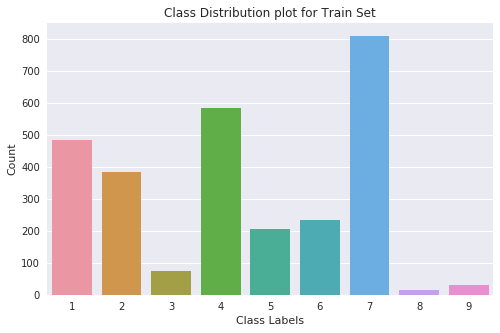

In [23]:
distribution_check(train_y, 'Train Set')

Class Distribution for Test Set:
Number of Data Points in Class 1 is 85 (17.0%)
Number of Data Points in Class 2 is 68 (14.0%)
Number of Data Points in Class 3 is 14 (3.0%)
Number of Data Points in Class 4 is 103 (21.0%)
Number of Data Points in Class 5 is 36 (7.0%)
Number of Data Points in Class 6 is 41 (8.0%)
Number of Data Points in Class 7 is 143 (29.0%)
Number of Data Points in Class 8 is 3 (1.0%)
Number of Data Points in Class 9 is 6 (1.0%)


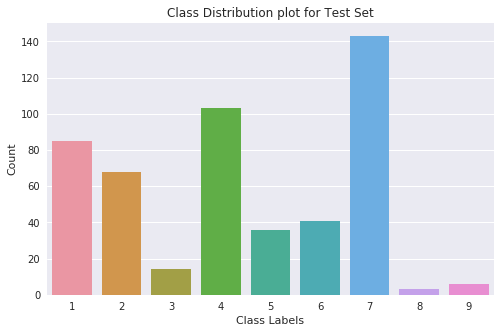

In [24]:
distribution_check(test_y, 'Test Set')

Class Distribution for Cross-Validation Set:
Number of Data Points in Class 1 is 87 (17.0%)
Number of Data Points in Class 2 is 69 (14.0%)
Number of Data Points in Class 3 is 13 (3.0%)
Number of Data Points in Class 4 is 105 (21.0%)
Number of Data Points in Class 5 is 37 (7.0%)
Number of Data Points in Class 6 is 42 (8.0%)
Number of Data Points in Class 7 is 146 (29.0%)
Number of Data Points in Class 8 is 3 (1.0%)
Number of Data Points in Class 9 is 6 (1.0%)


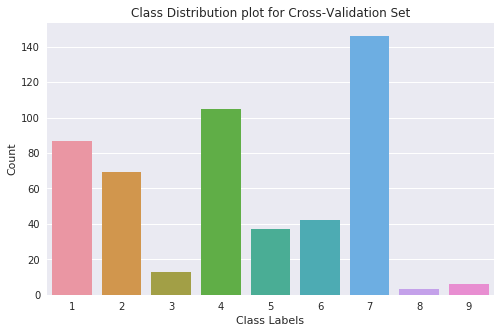

In [25]:
distribution_check(crossv_y, 'Cross-Validation Set')

### 5.1 Univariate Analysis 

In [26]:
def dist_plot(data, feature):
    
    sns.set()
    plt.figure(figsize = (10, 5))
    sns.distplot(data.values, color = 'b')
    plt.xlabel('Index of Gene')
    plt.ylabel('Num of Occurrence')
    plt.title('Distribution Plot for ' + feature)
    plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.plot(np.cumsum(data.values / sum(data.values)), color = 'b')
    plt.xlabel('Index of Gene')
    plt.ylabel('Cumulative Sum')
    plt.title('Cumulative Distribuition of ' + feature)
    plt.show()  

### [A] Gene

In [27]:
unique_genes = train_x['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
unique_genes.head(10)

Number of Unique Genes : 254


BRCA1     227
TP53      139
EGFR      118
BRCA2     108
PTEN      105
KIT        86
BRAF       85
ERBB2      61
ALK        55
PIK3CA     47
Name: Gene, dtype: int64

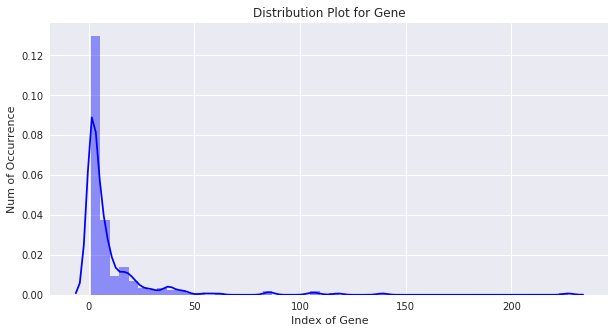

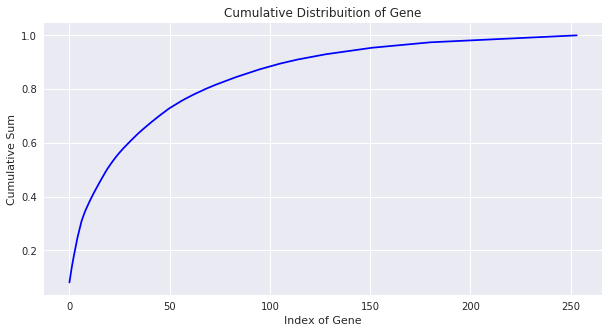

In [28]:
dist_plot(unique_genes, 'Gene')

### [B] Variation

In [29]:
unique_genes = train_x['Variation'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
unique_genes.head(10)

Number of Unique Genes : 2551


Truncating_Mutations    84
Deletion                60
Amplification           59
Fusions                 25
Overexpression           6
G12V                     4
Q61H                     3
T58I                     3
E17K                     3
Q61L                     3
Name: Variation, dtype: int64

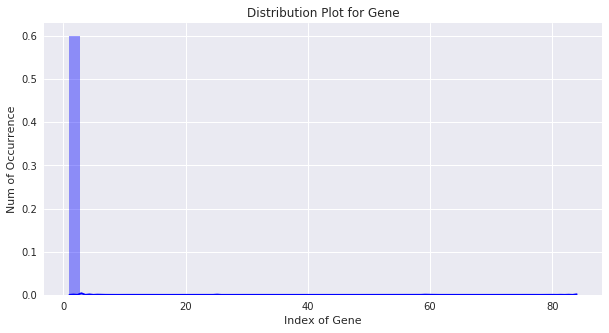

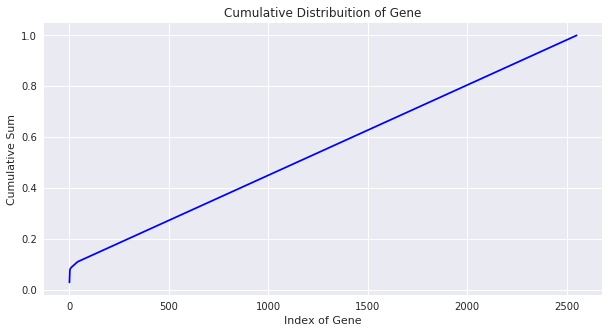

In [30]:
dist_plot(unique_genes, 'Gene')

In [29]:
def extract_dict(data):
    
    dictionary = defaultdict(int)
    for index, row in data.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    
    return dictionary

In [30]:
unique_words(train_x)

Total Number of Unique Words in Train Data :  61087


## 6. Prediction using a 'Random' Model 

In [33]:
def random_clf(ytrain, ytest):

    ytrain_dummy = np.zeros((1, len(np.unique(ytrain))))
    ytest_dummy = np.zeros((1, len(np.unique(ytest))))
    
    for i in range(len(ytrain)):
        random_probs = np.random.rand(1, len(np.unique(ytrain)))
        ytrain_dummy = np.vstack([ytrain_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Train-set using Random Model is ', log_loss(ytrain, ytrain_dummy[1:, :]))
    err_metrics(ytrain, np.argmax(ytrain_dummy[1:, :], axis = 1) + 1)
        
    for i in range(len(ytest)):
        random_probs = np.random.rand(1, len(np.unique(ytest)))
        ytest_dummy = np.vstack([ytest_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Test-set using Random Model is ', log_loss(ytest, ytest_dummy[1:, :]))
    err_metrics(ytest, (np.argmax(ytest_dummy[1:, :], axis = 1)) + 1)

In [28]:
def err_metrics(y, yhat):
    
    confuzn_mtx = confusion_matrix(y, yhat)
    precision_mtx = confuzn_mtx / confuzn_mtx.sum(axis = 0)
    recall_mtx = (confuzn_mtx.T / confuzn_mtx.sum(axis = 1)).T
    labels = np.unique(y)
    
    print('-'*40, 'CONFUSION-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(confuzn_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*40, 'PRECISION-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(precision_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*40, 'RECALL-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(recall_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log-Loss on Train-set using Random Model is  2.4865836511060393
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


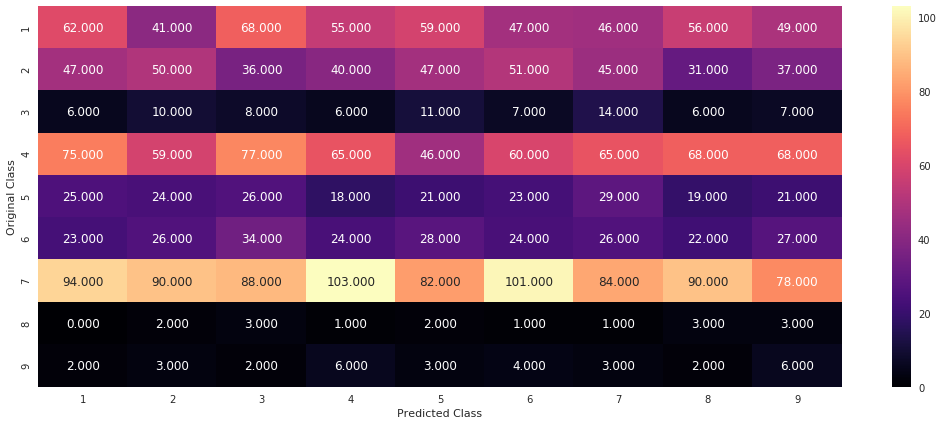

---------------------------------------- PRECISION-MATRIX ----------------------------------------


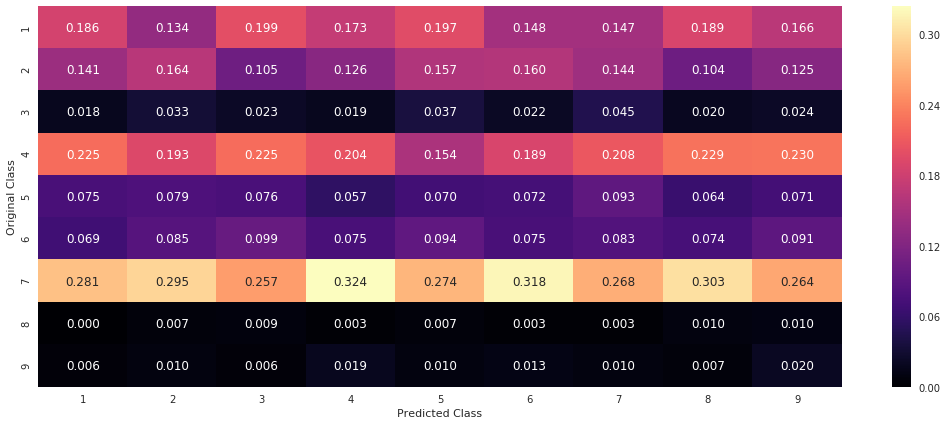

---------------------------------------- RECALL-MATRIX ----------------------------------------


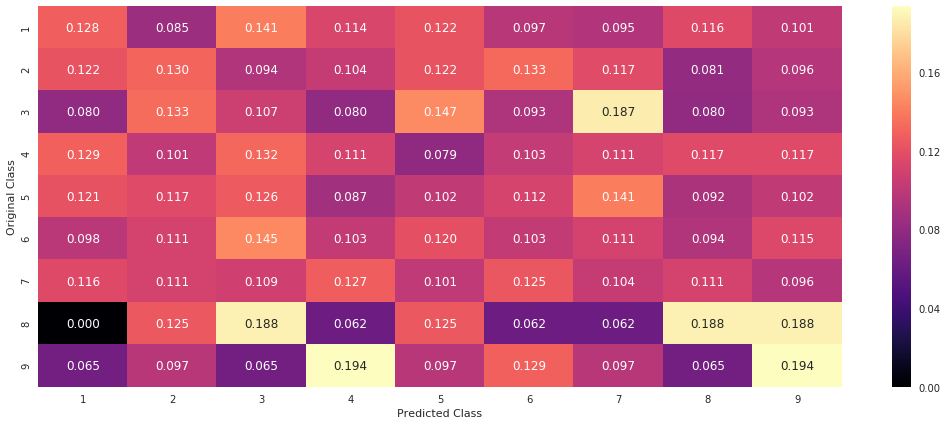

Log-Loss on Test-set using Random Model is  2.5222991011288554
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


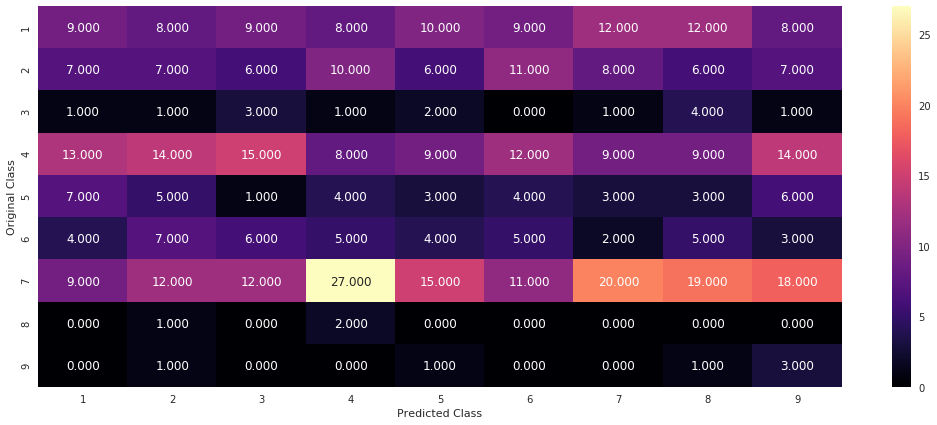

---------------------------------------- PRECISION-MATRIX ----------------------------------------


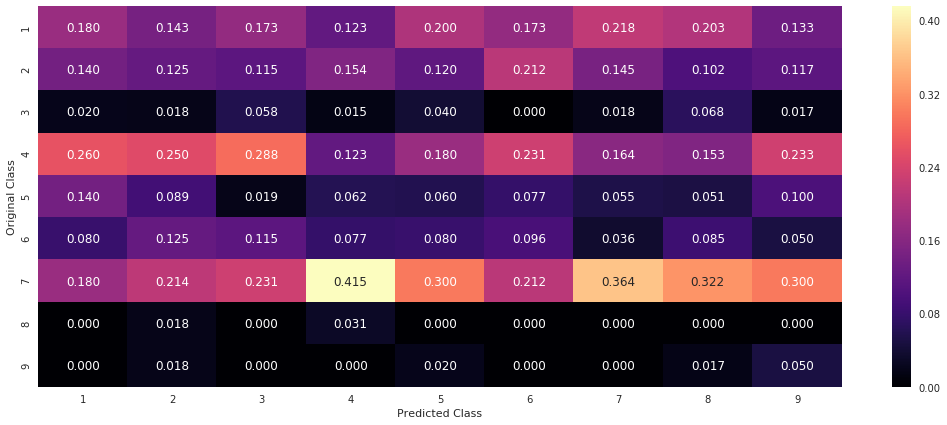

---------------------------------------- RECALL-MATRIX ----------------------------------------


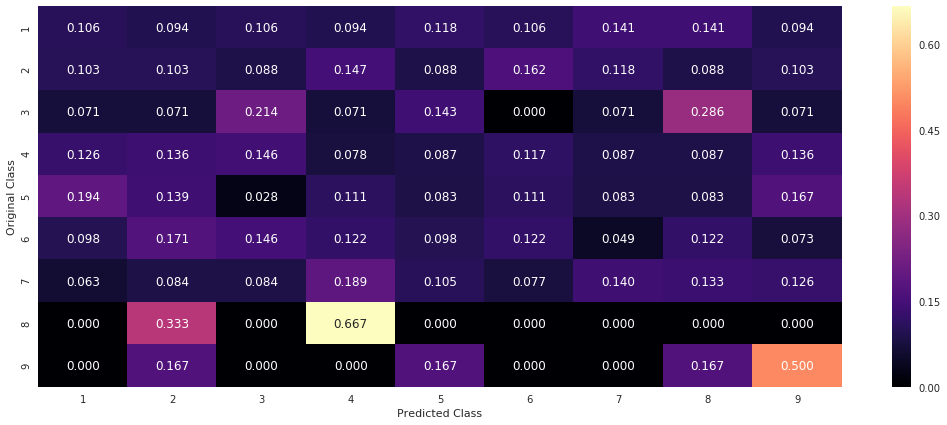

In [35]:
random_clf(train_y, test_y)

## 7. Feature Importance 

In [31]:
def feature_importance(feature, encode_type, operation, best_alpha = None):
    
    alpha = [10 ** x for x in range(-5, 1)]
    logloss_trn = []
    logloss_cv = []

    if operation == 'Training' and feature != 'TEXT':
        for i in alpha:
                
            if encode_type == 'OneHotEncode':
                trn_x, cv_x = onehot_encode(train_datax[feature], crossv_x[feature], np.unique(train_datax[feature]))
            else:
                trn_x, cv_x = response_encode(train_datax, train_datay, crossv_x, feature, 1)
    
            clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 32)
            clf.fit(trn_x, train_datay)
            
            trn_predproba = clf.predict_proba(trn_x)
            cv_predproba = clf.predict_proba(cv_x)
            
            logloss_trn.append(log_loss(train_datay, trn_predproba))
            logloss_cv.append(log_loss(crossv_y, cv_predproba))
        
        err_curve_sgd(logloss_trn, logloss_cv, alpha)
    
    elif operation == 'Testing' and feature != 'TEXT':
        if encode_type == 'OneHotEncode':
            trn_x, tst_x = onehot_encode(train_x[feature], test_x[feature], np.unique(train_x[feature]))
        else:
            trn_x, tst_x = response_encode(train_x, train_y, test_x, feature, 0.0001)
    
        clf = SGDClassifier(alpha = best_alpha, penalty = 'l2', loss = 'log', random_state = 32)
        clf.fit(trn_x, train_y)
        
        trn_predproba = clf.predict_proba(trn_x)
        tst_predproba = clf.predict_proba(tst_x)

        print('Log-Loss For Train-Set is :', log_loss(train_y, trn_predproba))
        print('Log-Loss For Test-set is  :', log_loss(test_y, tst_predproba))
        
    elif operation == 'Training' and feature == 'TEXT':
        for i in alpha:
                
                if encode_type == 'OneHotEncode':
                    trn_x, cv_x = text_onehot_encode(train_datax, crossv_x)
                else:
                    total_dict = extract_dict(train_datax)
                    dict_list = []
    
                    for i in range(1,10):
                        cls_text = train_datax[train_datay == i]
                        dict_list.append(extract_dict(cls_text))
                
                    trn_x = text_response_encode(train_datax, train_datay,
                                                 total_dict, dict_list)
                    cv_x = text_response_encode(crossv_x, crossv_y,
                                                 total_dict, dict_list)
    
                clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 32)
                clf.fit(trn_x, train_datay)
            
                trn_predproba = clf.predict_proba(trn_x)
                cv_predproba = clf.predict_proba(cv_x)
                
                trn_predproba = np.nan_to_num(trn_predproba)
                cv_predproba = np.nan_to_num(cv_predproba)
            
                logloss_trn.append(log_loss(train_datay, trn_predproba))
                logloss_cv.append(log_loss(crossv_y, cv_predproba))
        
        err_curve_sgd(logloss_trn, logloss_cv, alpha)
        
    else:
        if encode_type == 'OneHotEncode':
            trn_x, tst_x = text_onehot_encode(train_x, test_x)
        else:
            total_dict = extract_dict(train_x)
            dict_list = []
        
            for i in range(1,10):
                cls_text = train_x[train_y == i]
                dict_list.append(extract_dict(cls_text))
        
            trn_x = text_response_encode(train_x, train_y,
                                         total_dict, dict_list)
            tst_x = text_response_encode(test_x, test_y,
                                         total_dict, dict_list)
    
        clf = SGDClassifier(alpha = best_alpha, penalty = 'l2', loss = 'log', random_state = 32)
        clf.fit(trn_x, train_y)
        
        trn_predproba = clf.predict_proba(trn_x)
        tst_predproba = clf.predict_proba(tst_x)
        
        trn_predproba = np.nan_to_num(trn_predproba)
        tst_predproba = np.nan_to_num(tst_predproba)

        print('Log-Loss For Train-Set is :', log_loss(train_y, trn_predproba))
        print('Log-Loss For Test-set is  :', log_loss(test_y, tst_predproba))

In [32]:
def err_curve_sgd(train_loss, cv_loss, alpha):
    
    plt.figure(1)
    plt.figure(figsize = (8, 5))
    plt.plot(alpha, cv_loss, label = 'cv_error', color = 'r')
    plt.plot(alpha, train_loss, label = 'train_error', color = 'b')
    plt.xscale('log')
    plt.xlabel('Alpha-Values')
    plt.ylabel('Error Values')
    plt.legend()
    plt.title('CV & TRAIN-ERR')
    plt.show()

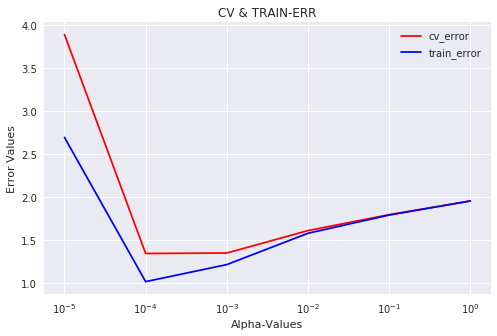

In [40]:
feature_importance('Gene', 'OneHotEncode', 'Training')

In [41]:
feature_importance('Gene', 'OneHotEncode', 'Testing', 0.0001)

Log-Loss For Train-Set is : 1.0685732627356777
Log-Loss For Test-set is  : 1.237384812767648


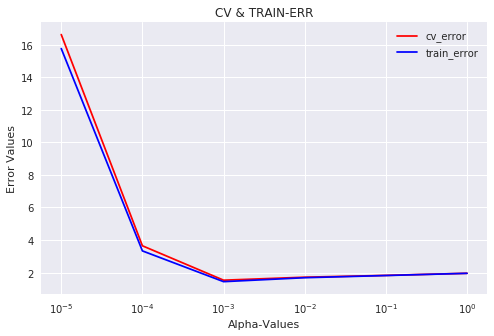

In [42]:
feature_importance('Gene', 'ResponseEncode', 'Training')

In [43]:
feature_importance('Gene', 'ResponseEncode', 'Testing', 0.001)

Log-Loss For Train-Set is : 1.041545734482319
Log-Loss For Test-set is  : 1.2048710613191744


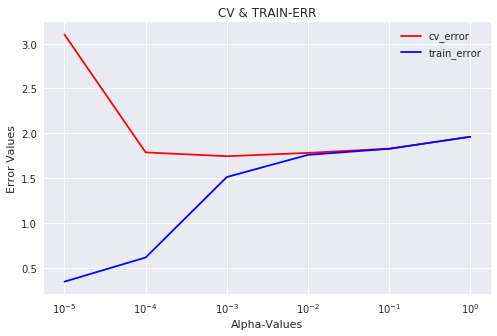

In [44]:
feature_importance('Variation', 'OneHotEncode', 'Training')

In [45]:
feature_importance('Variation', 'OneHotEncode', 'Testing', 0.01)

Log-Loss For Train-Set is : 1.7628699821944203
Log-Loss For Test-set is  : 1.7941017831331931


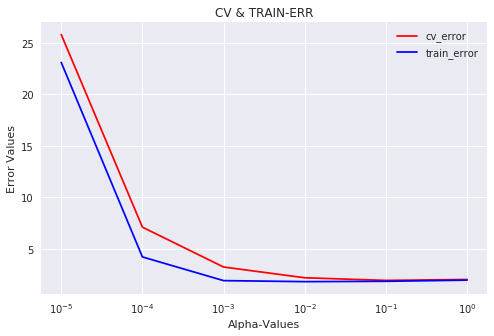

In [46]:
feature_importance('Variation', 'ResponseEncode', 'Training')

In [48]:
feature_importance('Variation', 'ResponseEncode', 'Testing', 0.1)

Log-Loss For Train-Set is : 1.2152123130770351
Log-Loss For Test-set is  : 1.8076090199751762


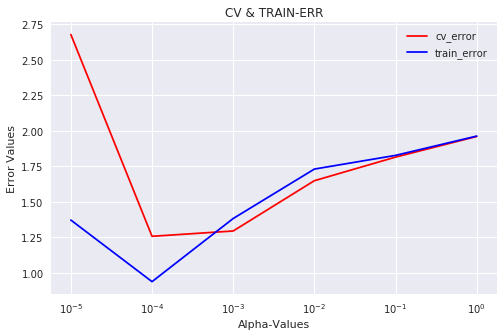

In [49]:
feature_importance('TEXT', 'OneHotEncode', 'Training')

In [51]:
feature_importance('TEXT', 'OneHotEncode', 'Testing', 0.0001)

Log-Loss For Train-Set is : 1.004897474350282
Log-Loss For Test-set is  : 1.1758396808765388


## 8. Machine Learning Models

### [A] Stacking All Features

In [39]:
def feature_stack(trn_data, trn_ydata, tst_data, tst_ydata, encode_type, vectorizer = None, ngram = None):
    
    if encode_type == 'OneHotEncode':
        
        gene_cat = np.unique(trn_data['Gene'])
        #var_cat = np.unique(trn_data['Variation'])
        trn_gene, tst_gene = onehot_encode(trn_data['Gene'], tst_data['Gene'], gene_cat)
        #trn_var, tst_var = onehot_encode(trn_data['Variation'], tst_data['Variation'], var_cat)
        trn_txt, tst_txt = text_onehot_encode(trn_data, tst_data, vectorizer, ngram)
        
        #print(trn_gene.shape, trn_var.shape, trn_txt.shape)
        #total_trn_data = pd.concat([trn_gene, trn_var], axis = 1)
        #total_trn_data = pd.concat([total_trn_data, trn_txt], axis = 1)
        #total_tst_data = pd.concat([tst_gene, tst_var], axis = 1)
        #total_tst_data = pd.concat([total_tst_data, tst_txt], axis = 1)
        total_trn_data = pd.concat([trn_gene, trn_txt], axis = 1)
        total_tst_data = pd.concat([tst_gene, tst_txt], axis = 1)
        
        
    else:
        total_dict = extract_dict(trn_data)
        dict_list = []
        
        for i in range(1,10):
            cls_text = trn_data[trn_ydata == i]
            dict_list.append(extract_dict(cls_text))
        
        trn_gene, tst_gene = response_encode(trn_data, trn_ydata, tst_data, 'Gene', 100000)
        trn_var, tst_var = response_encode(trn_data, trn_ydata, tst_data, 'Variation', 100000)
        trn_txt = text_response_encode(trn_data, trn_ydata, total_dict, dict_list)
        tst_txt = text_response_encode(tst_data, tst_ydata, total_dict, dict_list)
        
        total_trn_data = normalize(np.hstack([trn_gene, trn_var, trn_txt]), axis = 0)
        total_tst_data = normalize(np.hstack([tst_gene, tst_var, tst_txt]), axis = 0)
        
    return total_trn_data, total_tst_data

### 8.1 Naive Bayes

In [90]:
def naive_bayes_model(operation, encode_type, best_alpha = None, vectorizer = None, ngram = None):
    
    alpha = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for a in alpha:
            clf = MultinomialNB(alpha = a, fit_prior = False)
            clf.fit(trn_data, train_datay)
            pred_proba_trn = clf.predict_proba(trn_data)
            pred_proba_cv = clf.predict_proba(cv_data)
            train_err.append(log_loss(train_datay, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, alpha, 'Alpha')
    else:
        clf = MultinomialNB(best_alpha, fit_prior = False)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type, vectorizer, ngram)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_tst = clf.predict_proba(tst_data)
        trn_err = (1 - clf.score(trn_data, train_y))
        tst_err = (1 - clf.score(tst_data, test_y))
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [91]:
def nb_query(best_alpha, query_indx, vectorizer = None, ngram = None):

    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode', vectorizer, ngram)
    clf = MultinomialNB(best_alpha, fit_prior = False)
    clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = (-clf.feature_log_prob_[pred_cls - 1]).argsort()[:, :num_feature]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in np.unique(train_x['Gene']):
                print('Feature from Gene :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            elif tst_data.columns[i] in np.unique(train_x['Variation']):
                print('Feature from Variation :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            else:
                print('Feature from TEXT',tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
    present_word = []
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in test_x['TEXT'].iloc[query_indx]:
                present_word.append(tst_data.columns[i])
    print('These Texts are present in the given query : ')
    print(present_word)

In [41]:
def err_compare(train_err, cv_err, hyp_param, param_name):
    sns.set()
    plt.figure(1)
    plt.figure(figsize=(8, 5))
    plt.plot(hyp_param, cv_err, label = 'cv_error', color = 'r')
    plt.plot(hyp_param, train_err, label = 'train_error', color = 'b')
    if param_name != 'K':
        plt.xscale('log')
    plt.xlabel(param_name + ' Values')
    plt.ylabel('Log-Loss Values')
    plt.legend()
    plt.title('CV & TRAIN-ERR')

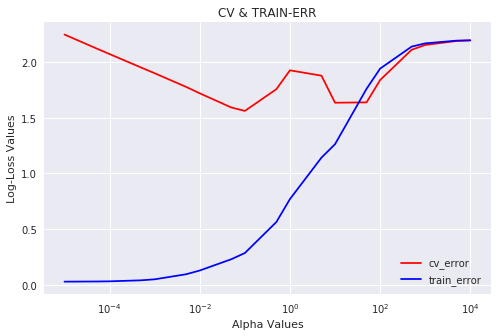

In [56]:
naive_bayes_model('Training', 'OneHotEncode')

Log-Loss for Train-set is : 1.8762458514322848
Log-Loss for Test-set is : 1.7516607929379144
Train Accuracy is : 0.44153082919914954
Test Accuracy is : 0.5050100200400802
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


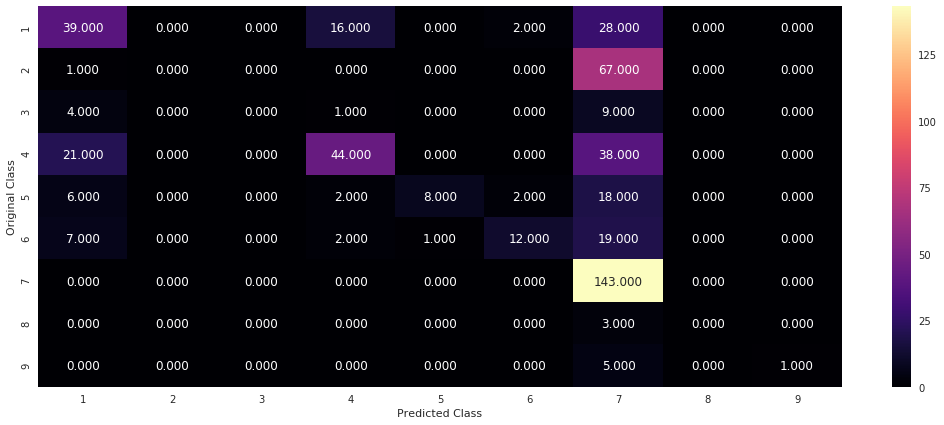

---------------------------------------- PRECISION-MATRIX ----------------------------------------


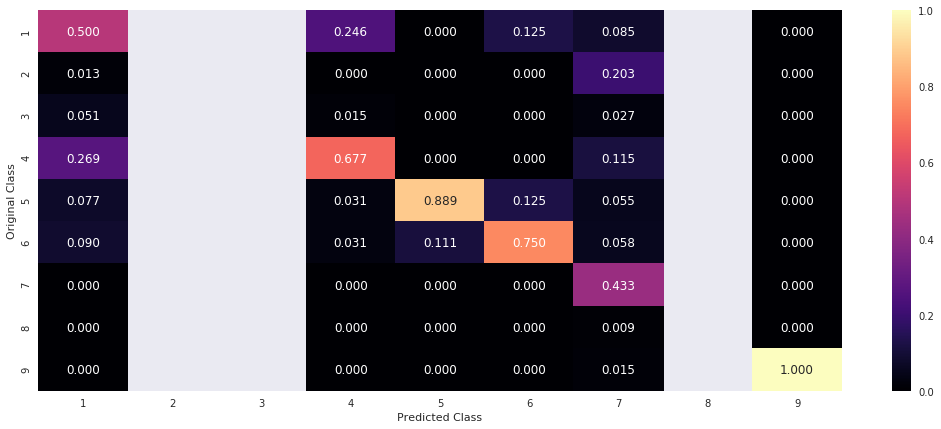

---------------------------------------- RECALL-MATRIX ----------------------------------------


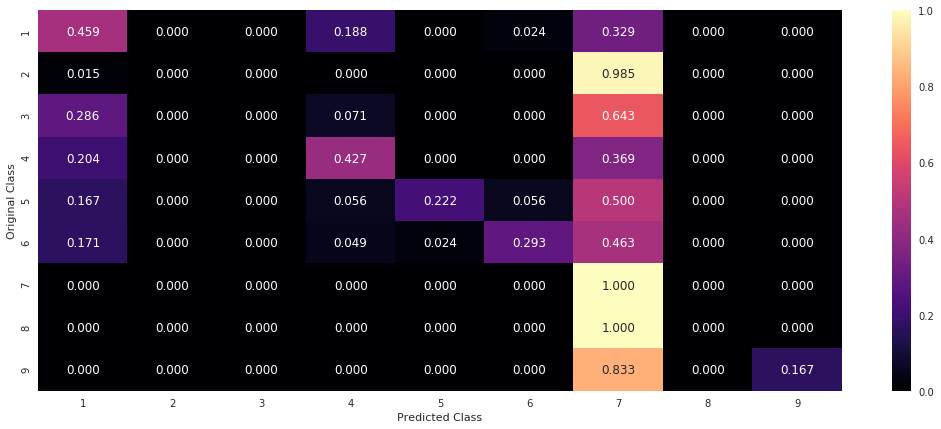

In [60]:
naive_bayes_model('Testing', 'OneHotEncode', 85)

In [68]:
nb_query(100, 5)

Predicted Class :  7
Actual Class :  7
----------------------------------------
Feature from Gene : EGFR 1
Feature from Gene : KIT 0
Feature from Gene : BRAF 0
Feature from Gene : ALK 0
Feature from Variation : Amplification 0
Feature from Gene : PDGFRA 0
Feature from Gene : KRAS 0
Feature from Gene : FLT3 0
Feature from Gene : ERBB2 0
Feature from Gene : PIK3CA 0
Feature from Gene : FGFR2 0
Feature from Gene : CTNNB1 0
Feature from Gene : MAP2K1 0
Feature from Gene : MTOR 0
Feature from Gene : MET 0
Feature from Gene : NFE2L2 0
Feature from Gene : RET 0
Feature from TEXT activation 0.023016213817670307
Feature from Gene : JAK1 0
Feature from TEXT activated 0.02594491822226598
Feature from TEXT kinase 0.05409947529097857
Feature from TEXT downstream 0.025754807323800935
Feature from TEXT inhibitor 0.03011477973914736
Feature from TEXT cells 0.018811715195837304
Feature from TEXT expressing 0.0035485898393897244
Feature from TEXT independent 0.025018381472854696
Feature from TEXT signal

In [69]:
nb_query(100, 1)

Predicted Class :  7
Actual Class :  1
----------------------------------------
Feature from Gene : EGFR 0
Feature from Gene : KIT 0
Feature from Gene : BRAF 0
Feature from Gene : ALK 0
Feature from Variation : Amplification 0
Feature from Gene : PDGFRA 0
Feature from Gene : KRAS 0
Feature from Gene : FLT3 0
Feature from Gene : ERBB2 0
Feature from Gene : PIK3CA 0
Feature from Gene : FGFR2 0
Feature from Gene : CTNNB1 0
Feature from Gene : MAP2K1 0
Feature from Gene : MTOR 0
Feature from Gene : MET 0
Feature from Gene : NFE2L2 0
Feature from Gene : RET 0
Feature from TEXT activation 0.007428197055807716
Feature from Gene : JAK1 0
Feature from TEXT activated 0.02093350004028981
Feature from TEXT kinase 0.02424990766295915
Feature from TEXT downstream 0.0
Feature from TEXT inhibitor 0.0
Feature from TEXT cells 0.0679156484604768
Feature from TEXT expressing 0.0
Feature from TEXT independent 0.03588609685134358
Feature from TEXT signaling 0.05207811644529582
Feature from TEXT contrast 0.0

### 8.2 KNN

In [70]:
def knn_model(operation, encode_type, best_k = None, vectorizer = None, ngram = None):
    
    k_val = np.arange(2, 100, 3)
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for k in k_val:
            clf = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
            clf.fit(trn_data, train_datay)
            pred_proba_trn = clf.predict_proba(trn_data)
            pred_proba_cv = clf.predict_proba(cv_data)
            train_err.append(log_loss(train_datay, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, k_val, 'K')
    else:
        clf = KNeighborsClassifier(n_neighbors = best_k, n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type, vectorizer, ngram)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_tst = clf.predict_proba(tst_data)
        trn_err = (1 - clf.score(trn_data, train_y))
        tst_err = (1 - clf.score(tst_data, test_y))
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [79]:
def knn_query(best_k, query_indx, encode, vectorizer = None, ngram = None):
    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode, vectorizer, ngram)
    clf = KNeighborsClassifier(n_neighbors = best_k, n_jobs = -1)
    clf.fit(trn_data, train_y)
    num_feature = 100
    if encode == 'OneHotEncode':
        pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    else:
        pred_cls = clf.predict(tst_data[query_indx].reshape(1, -1))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    if encode == 'OneHotEncode':
        neighbors = clf.kneighbors(tst_data.iloc[query_indx].reshape(1, -1), best_k)
    else:
        neighbors = clf.kneighbors(tst_data[query_indx].reshape(1, -1), best_k)
    print("The ",best_k," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
    print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

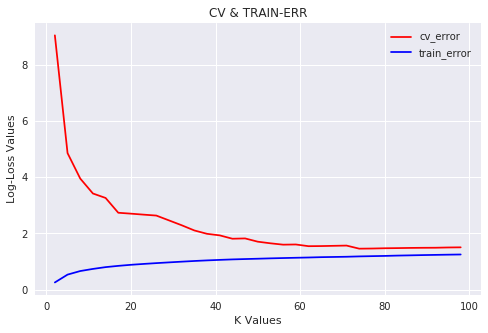

In [71]:
knn_model('Training', 'OneHotEncode')

Log-Loss for Train-set is : 1.1476045100344974
Log-Loss for Test-set is : 1.4629993068450782
Train Accuracy is : 0.4500354358610914
Test Accuracy is : 0.46893787575150303
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


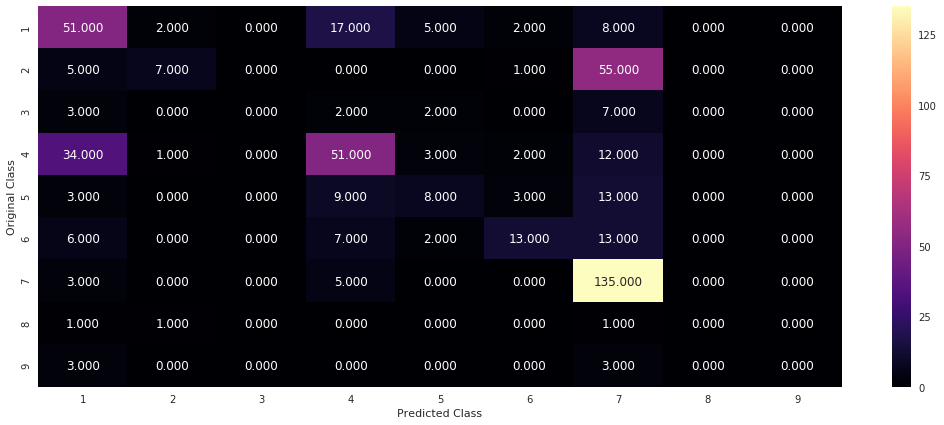

---------------------------------------- PRECISION-MATRIX ----------------------------------------


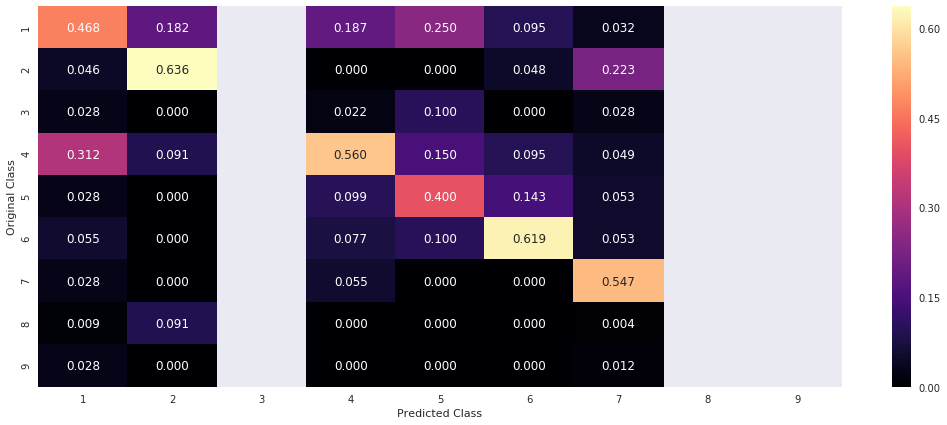

---------------------------------------- RECALL-MATRIX ----------------------------------------


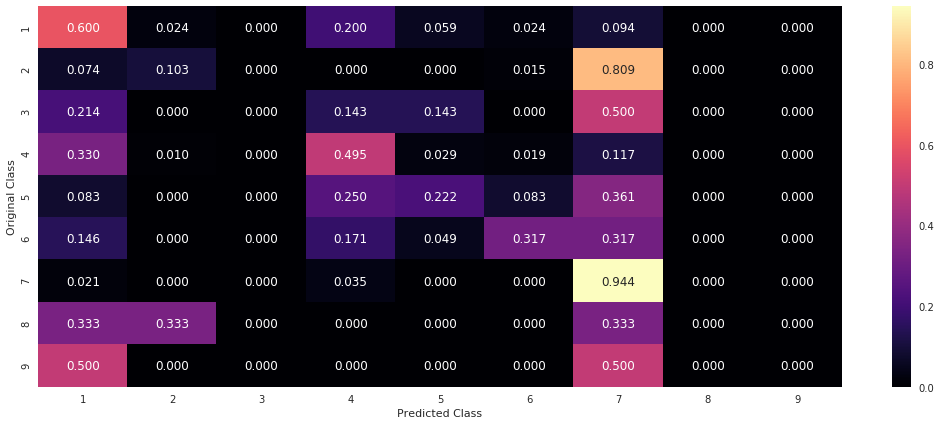

In [72]:
knn_model('Testing', 'OneHotEncode', 75)

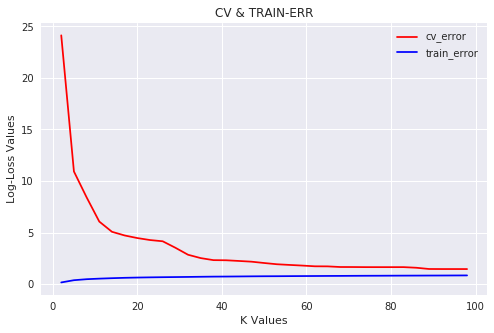

In [73]:
knn_model('Training', 'ResponseEncode')

Log-Loss for Train-set is : 0.8275182636383571
Log-Loss for Test-set is : 1.598997980357009
Train Accuracy is : 0.3114812189936216
Test Accuracy is : 0.5731462925851704
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


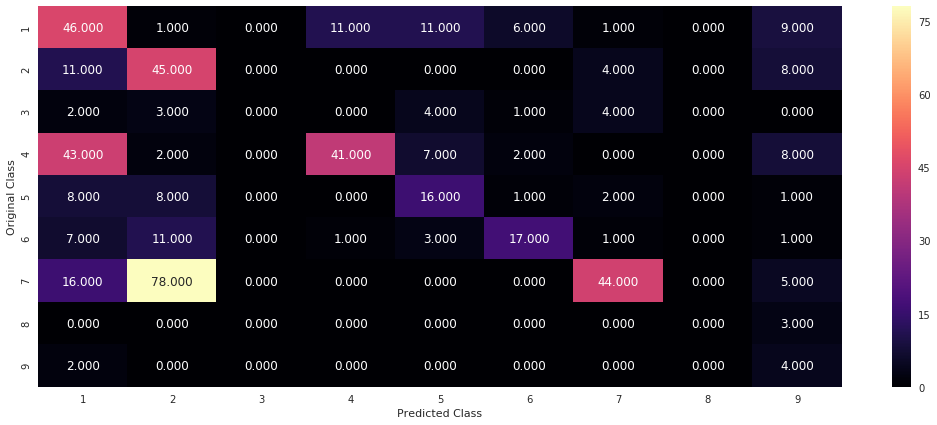

---------------------------------------- PRECISION-MATRIX ----------------------------------------


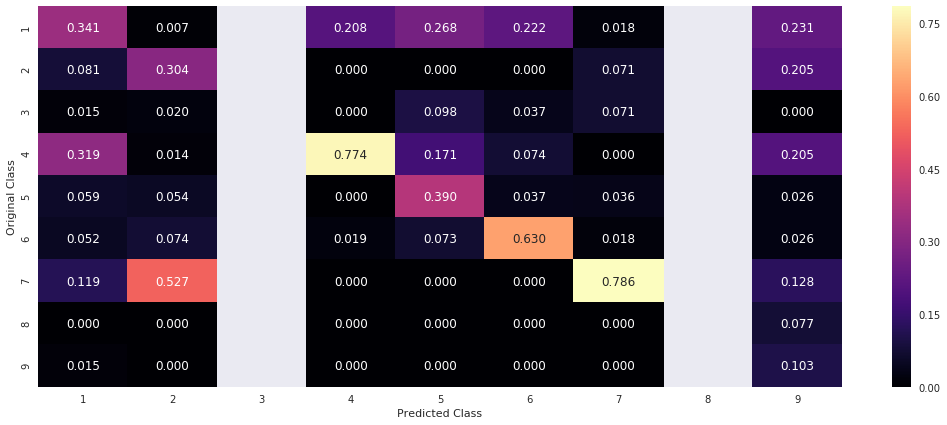

---------------------------------------- RECALL-MATRIX ----------------------------------------


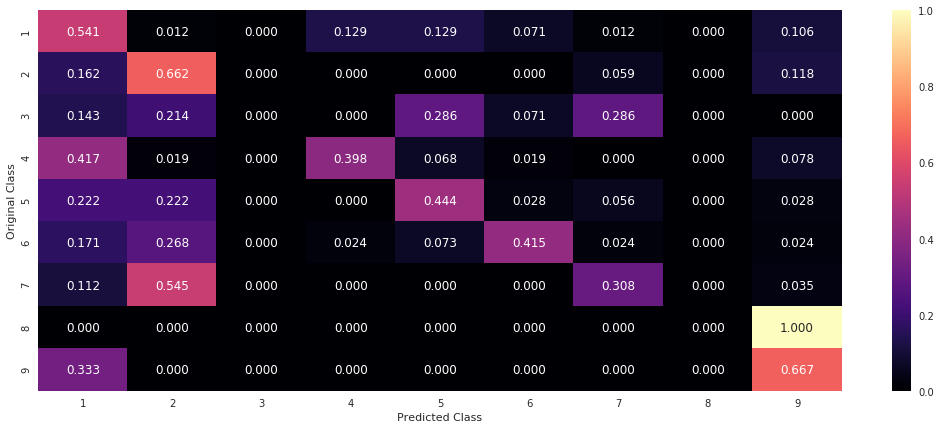

In [74]:
knn_model('Testing', 'ResponseEncode', 90)

In [80]:
knn_query(75, 1, 'OneHotEncode')

Predicted Class :  4
Actual Class :  1
----------------------------------------
The  75  nearest neighbours of the test points belongs to classes [1 1 7 1 4 7 7 9 4 7 1 9 7 1 4 1 4 4 4 4 4 6 6 7 7 4 1 1 2 7 7 1 2 2 4 4 2
 7 7 5 1 8 1 6 7 4 2 8 8 1 4 4 7 7 7 4 4 4 9 9 9 4 7 1 4 5 1 1 1 7 1 7 4 4
 4]
Fequency of nearest points : Counter({4: 22, 7: 18, 1: 17, 9: 5, 2: 5, 6: 3, 8: 3, 5: 2})


In [81]:
knn_query(90, 1, 'ResponseEncode')

Predicted Class :  1
Actual Class :  1
----------------------------------------
The  90  nearest neighbours of the test points belongs to classes [2 2 2 4 4 2 4 4 4 1 1 5 5 6 6 6 1 1 1 1 8 9 1 1 8 8 1 7 7 8 9 1 1 2 2 9 9
 7 1 5 5 5 5 9 4 4 4 7 4 9 9 8 4 1 8 9 8 2 1 1 4 3 1 1 4 1 7 6 9 9 9 1 8 2
 9 9 4 4 7 7 1 1 9 9 9 9 4 4 1 9]
Fequency of nearest points : Counter({1: 22, 9: 18, 4: 16, 2: 8, 8: 8, 7: 7, 5: 6, 6: 4, 3: 1})


### 8.3 Logistic Regression

In [36]:
def logistic_model(operation, encode_type, weight = None, best_alpha = None, vectorizer = None, ngram = None):
    
    alpha = alpha = [10 ** x for x in range(-6, 3)]
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for a in alpha:
            clf = SGDClassifier(class_weight = weight, alpha = a, penalty = 'l2', loss = 'log', n_jobs = -1)
            clf.fit(trn_data, train_datay)
            pred_proba_trn = clf.predict_proba(trn_data)
            pred_proba_cv = clf.predict_proba(cv_data)
            train_err.append(log_loss(train_datay, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, alpha, 'Alpha')
    else:
        clf = SGDClassifier(class_weight = weight, alpha = best_alpha, penalty = 'l2', loss = 'log', n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_tst = clf.predict_proba(tst_data)
        trn_err = (1 - clf.score(trn_data, train_y))
        tst_err = (1 - clf.score(tst_data, test_y))
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [43]:
def lr_query(best_alpha, query_indx, weight = None, vectorizer = None, ngram = None):

    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode', vectorizer, ngram)
    clf = SGDClassifier(class_weight = weight, alpha = best_alpha, penalty = 'l2', loss = 'log', n_jobs = -1)
    clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print("Predicted Class Probabilities:", np.round(clf.predict_proba(tst_data.iloc[query_indx].reshape(1, -1)), 4))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = (-clf.coef_[pred_cls - 1]).argsort()[:, :num_feature]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in np.unique(train_x['Gene']):
                print('Feature from Gene :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            elif tst_data.columns[i] in np.unique(train_x['Variation']):
                print('Feature from Variation :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            else:
                print('Feature from TEXT',tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
    present_word = []
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in test_x['TEXT'].iloc[query_indx]:
                present_word.append(tst_data.columns[i])
    print('These Texts are present in the given query : ')
    print(present_word)

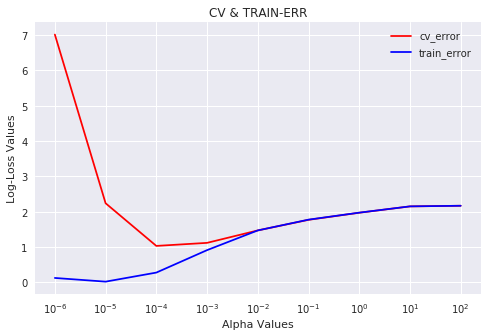

In [83]:
logistic_model('Training', 'OneHotEncode')

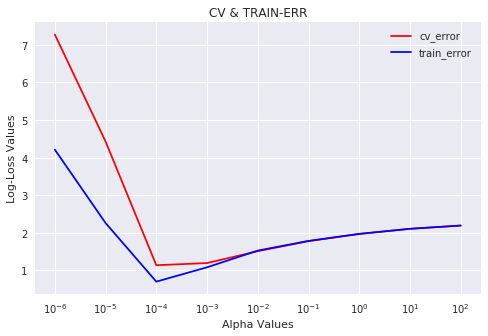

In [42]:
########
logistic_model('Training', 'OneHotEncode')

Log-Loss for Train-set is : 0.9666126774819147
Log-Loss for Test-set is : 1.0998914401152722
Train Accuracy is : 0.2622253720765415
Test Accuracy is : 0.36072144288577157
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


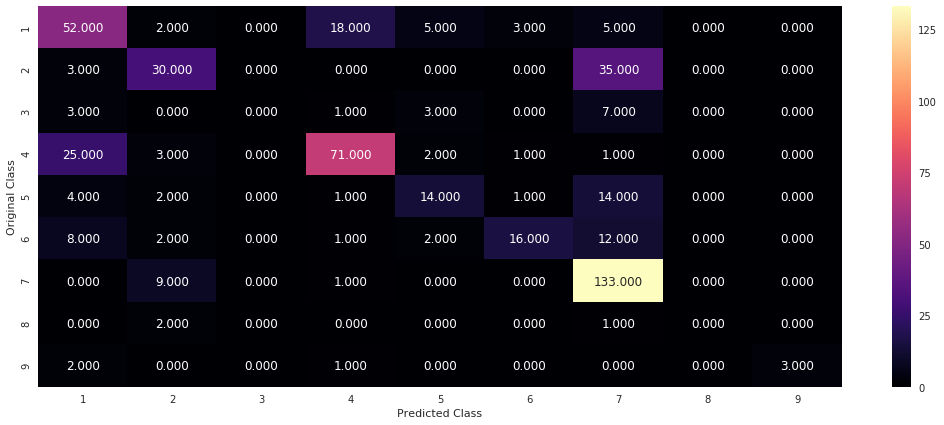

---------------------------------------- PRECISION-MATRIX ----------------------------------------


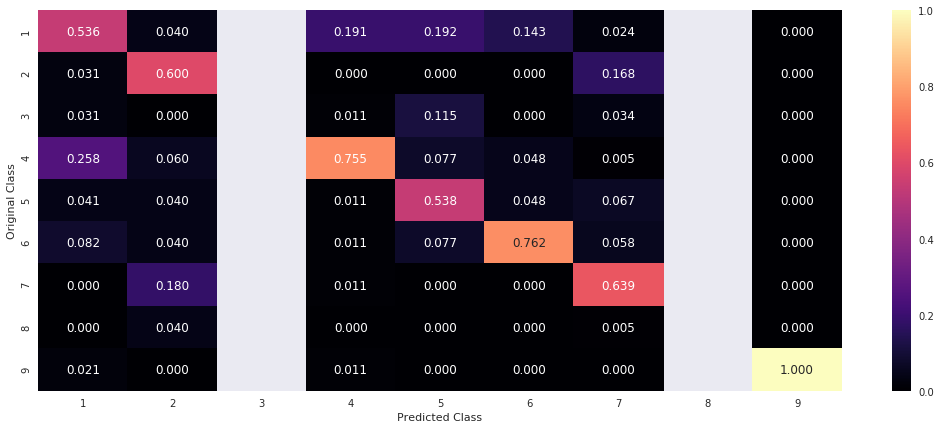

---------------------------------------- RECALL-MATRIX ----------------------------------------


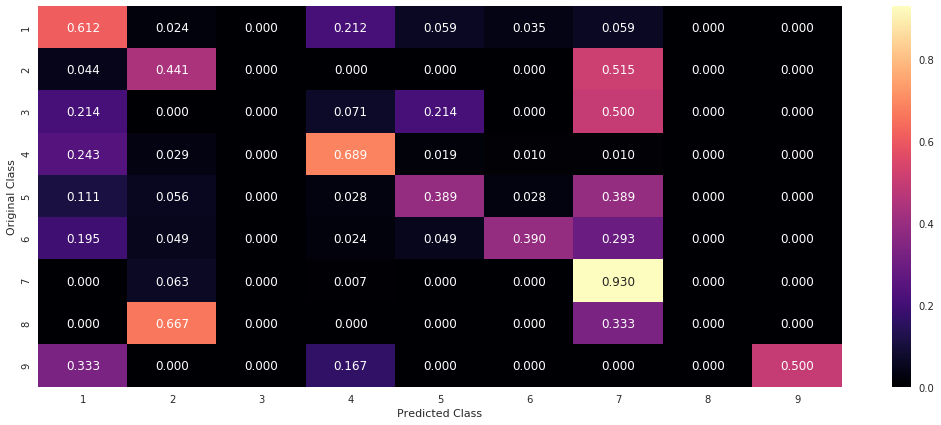

In [84]:
logistic_model('Testing', 'OneHotEncode', best_alpha = 0.001)

In [45]:
logistic_model('Testing', 'OneHotEncode', best_alpha = 0.001)

Log-Loss for Train-set is : 1.1252868131640101
Log-Loss for Test-set is : 1.1638838808876895
Train Accuracy is : 0.36817859673990083
Test Accuracy is : 0.4128256513026052


NameError: name 'err_metrics' is not defined

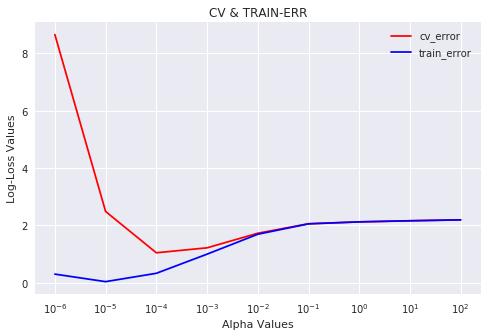

In [85]:
logistic_model('Training', 'OneHotEncode', weight = 'balanced')

Log-Loss for Train-set is : 1.0552602439021546
Log-Loss for Test-set is : 1.1738747812949388
Train Accuracy is : 0.2530120481927711
Test Accuracy is : 0.39078156312625245
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


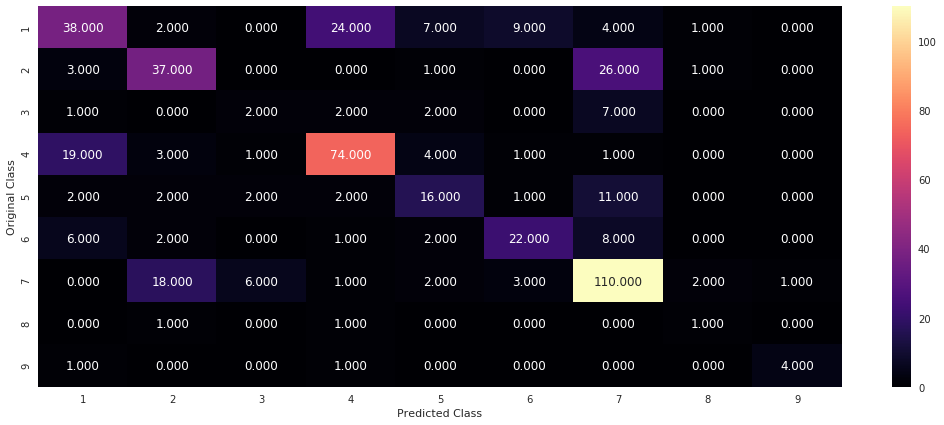

---------------------------------------- PRECISION-MATRIX ----------------------------------------


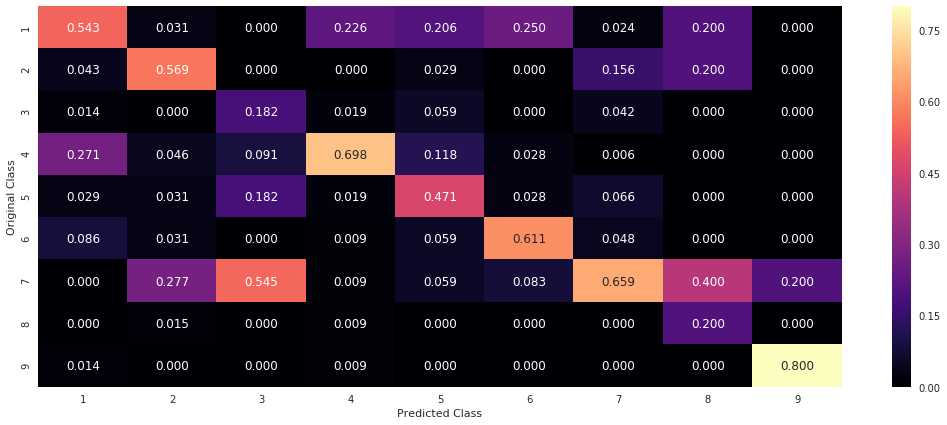

---------------------------------------- RECALL-MATRIX ----------------------------------------


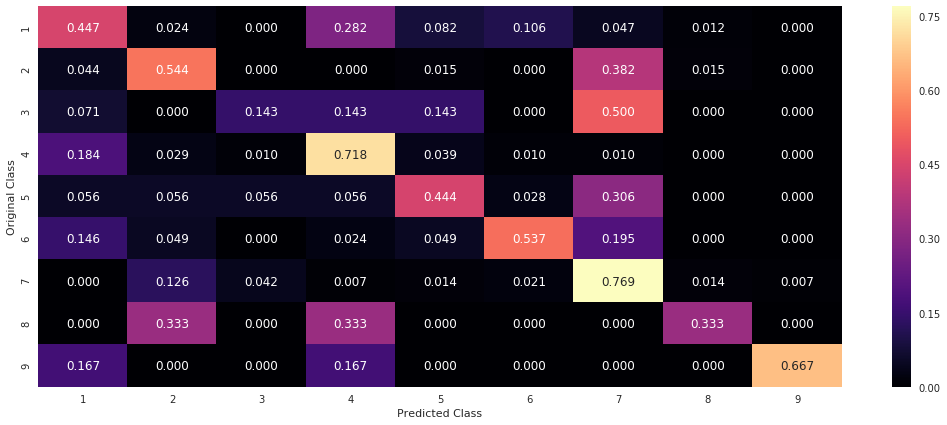

In [86]:
logistic_model('Testing', 'OneHotEncode', weight = 'balanced', best_alpha = 0.001)

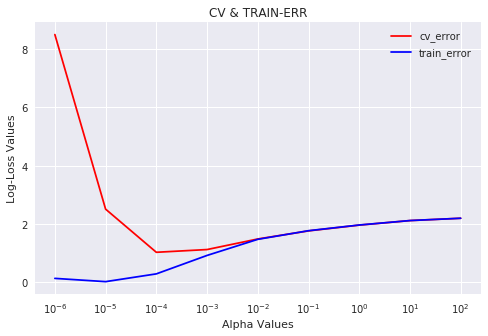

In [26]:
logistic_model('Training', 'OneHotEncode', vectorizer = 'CountVectorizer', ngram = 'Unigram')

Log-Loss for Train-set is : 0.9583214959112929
Log-Loss for Test-set is : 1.100727510238424
Train Accuracy is : 0.28277817150956763
Test Accuracy is : 0.36272545090180364
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


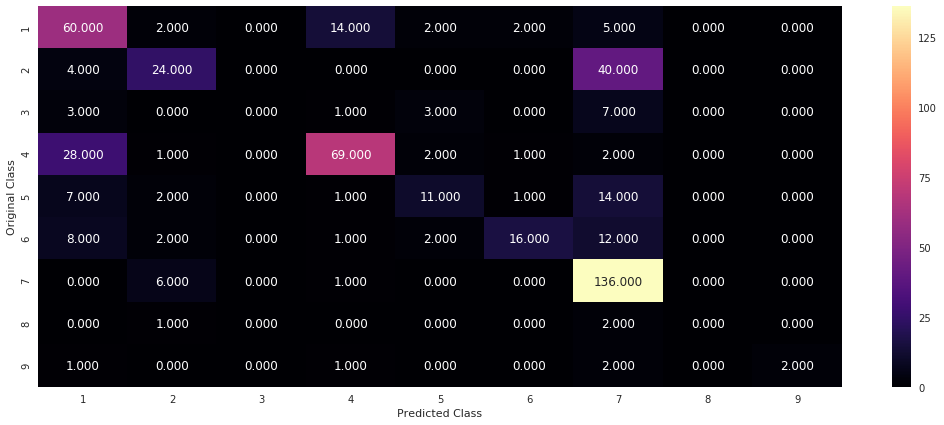

---------------------------------------- PRECISION-MATRIX ----------------------------------------


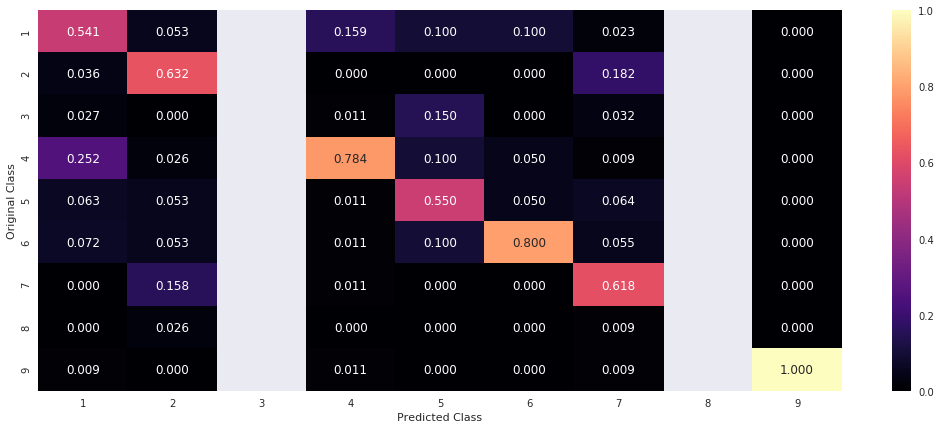

---------------------------------------- RECALL-MATRIX ----------------------------------------


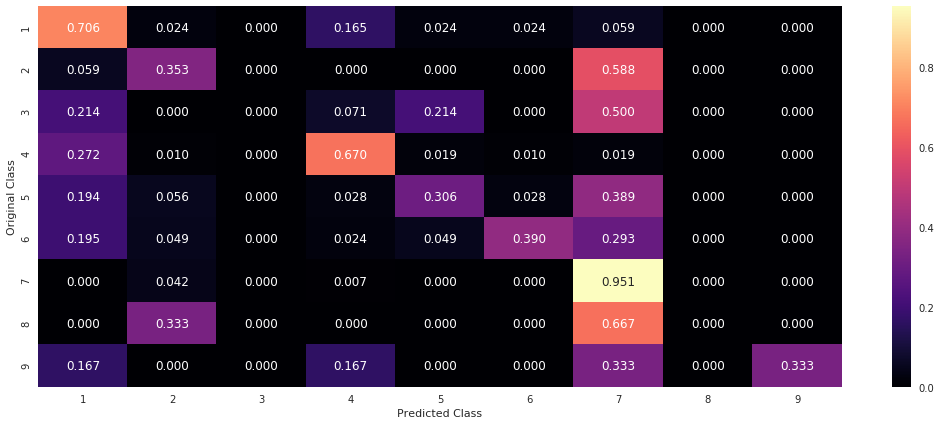

In [29]:
logistic_model('Testing', 'OneHotEncode', best_alpha = 0.001, vectorizer = 'CountVectorizer', ngram = 'Unigram')

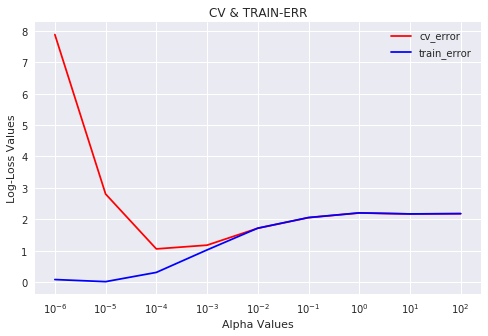

In [30]:
logistic_model('Training', 'OneHotEncode', weight = 'balanced', vectorizer = 'CountVectorizer', ngram = 'Unigram')

Log-Loss for Train-set is : 1.0297693493158224
Log-Loss for Test-set is : 1.1792416856459793
Train Accuracy is : 0.2576187101346563
Test Accuracy is : 0.3887775551102205
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


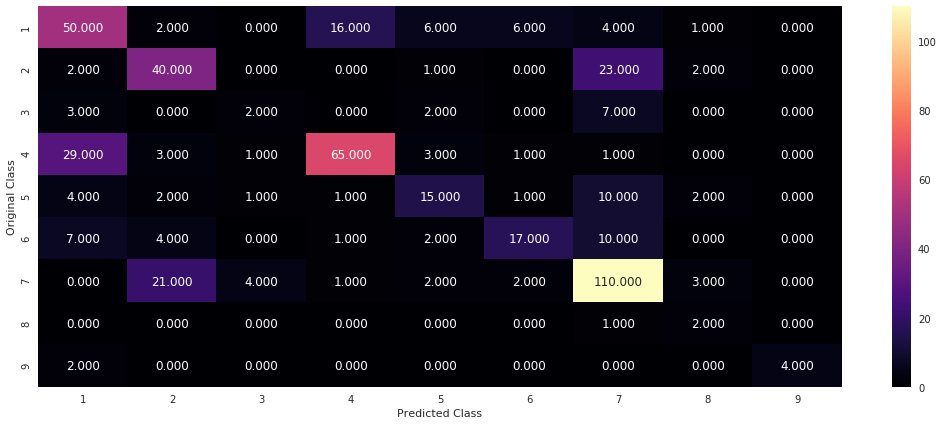

---------------------------------------- PRECISION-MATRIX ----------------------------------------


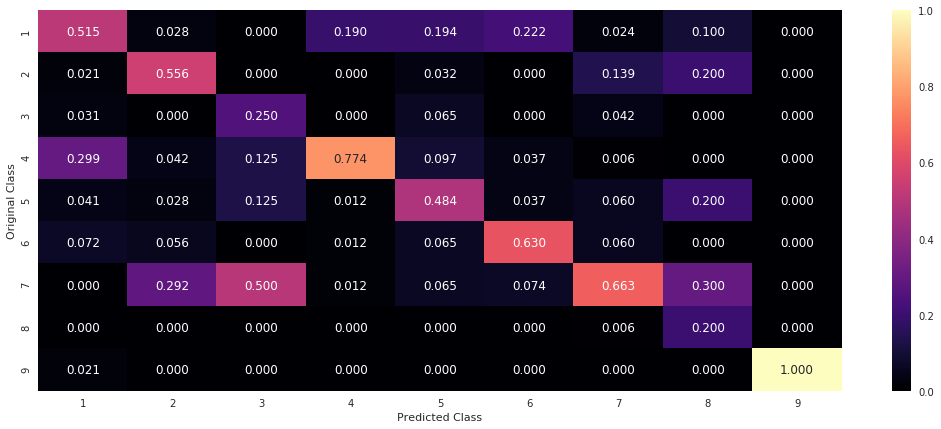

---------------------------------------- RECALL-MATRIX ----------------------------------------


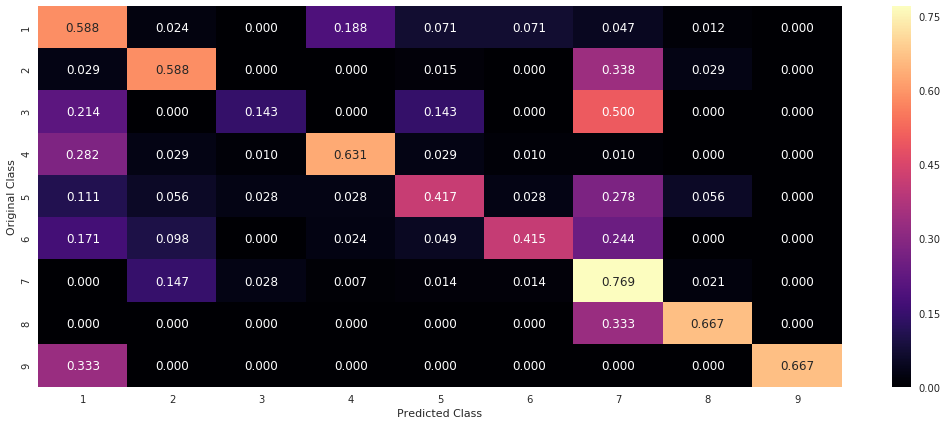

In [31]:
logistic_model('Testing', 'OneHotEncode', best_alpha = 0.001, weight = 'balanced', vectorizer = 'CountVectorizer', ngram = 'Unigram')

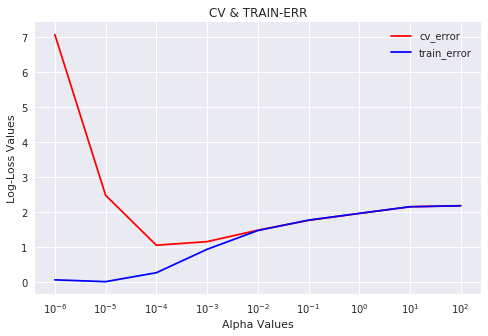

In [32]:
logistic_model('Training', 'OneHotEncode', vectorizer = 'CountVectorizer', ngram = 'Bigram')

Log-Loss for Train-set is : 0.9716716619967333
Log-Loss for Test-set is : 1.10176962309463
Train Accuracy is : 0.2895109851169383
Test Accuracy is : 0.37474949899799603
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


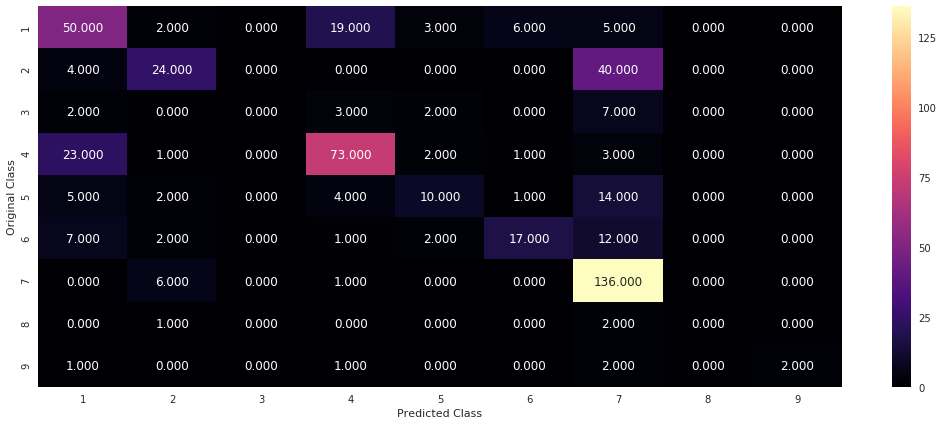

---------------------------------------- PRECISION-MATRIX ----------------------------------------


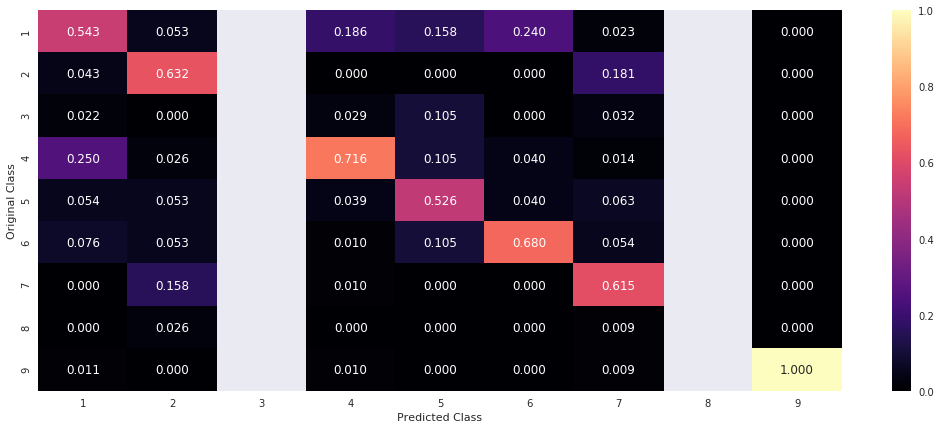

---------------------------------------- RECALL-MATRIX ----------------------------------------


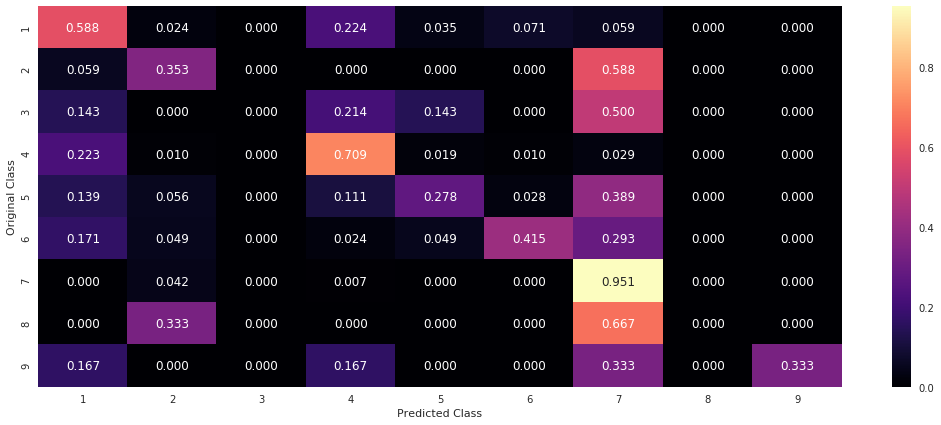

In [33]:
logistic_model('Testing', 'OneHotEncode', best_alpha = 0.001, vectorizer = 'CountVectorizer', ngram = 'Bigram')

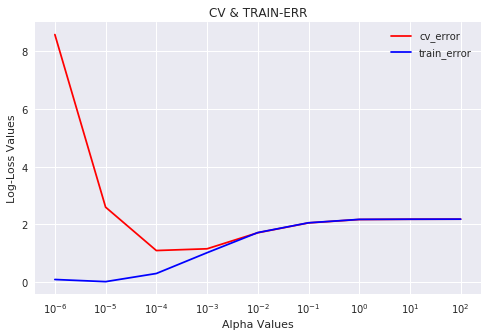

In [34]:
logistic_model('Training', 'OneHotEncode', weight = 'balanced', vectorizer = 'CountVectorizer', ngram = 'Bigram')

Log-Loss for Train-set is : 1.059376091969238
Log-Loss for Test-set is : 1.1819431078147826
Train Accuracy is : 0.2657689581856839
Test Accuracy is : 0.3887775551102205
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


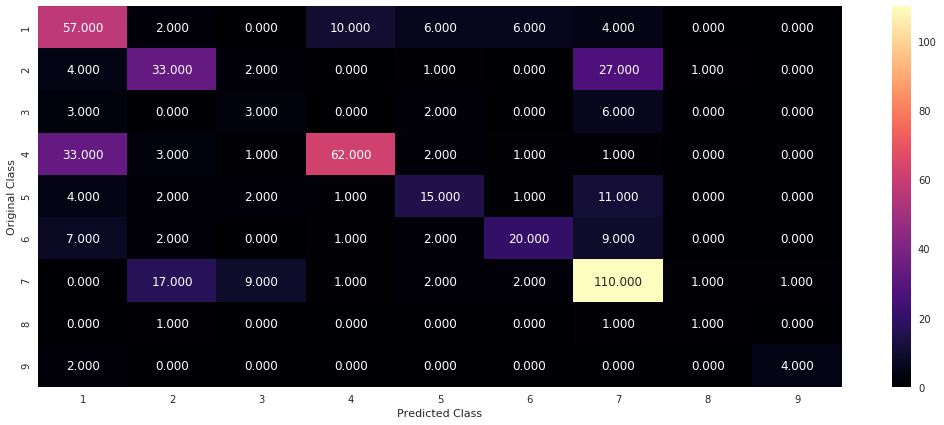

---------------------------------------- PRECISION-MATRIX ----------------------------------------


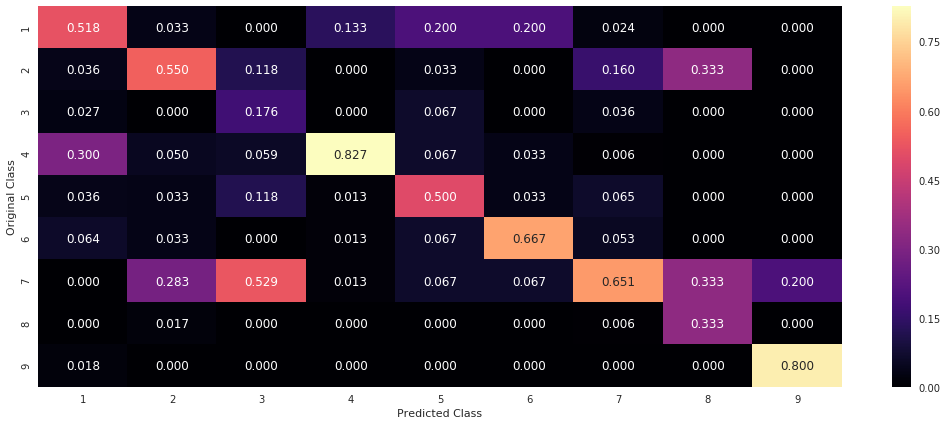

---------------------------------------- RECALL-MATRIX ----------------------------------------


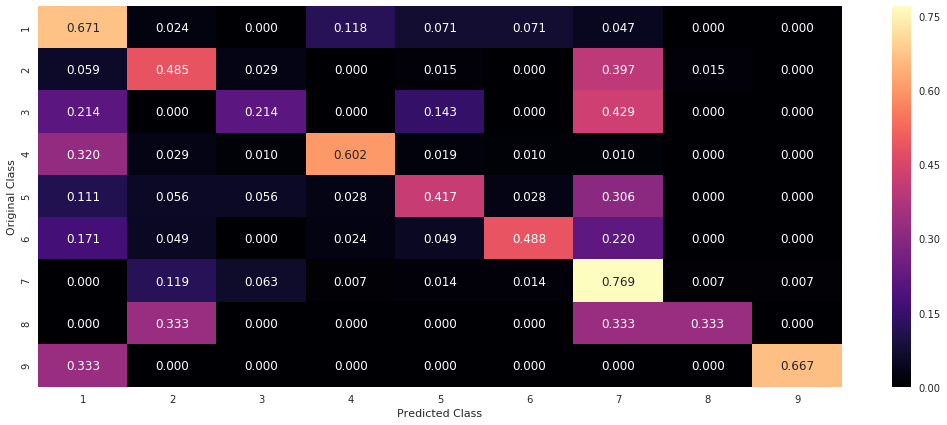

In [35]:
logistic_model('Testing', 'OneHotEncode', best_alpha = 0.001, weight = 'balanced', vectorizer = 'CountVectorizer', ngram = 'Bigram')

In [49]:
lr_query(0.001, 300, vectorizer = 'CountVectorizer', ngram = 'Unigram')

Predicted Class Probabilities: [[0.1192 0.0048 0.0381 0.3883 0.3971 0.0291 0.0127 0.0039 0.0067]]
Predicted Class :  5
Actual Class :  1
----------------------------------------
Feature from Gene : BRCA1 1
Feature from Gene : IDH1 0
Feature from Gene : FGFR3 0
Feature from Gene : PMS2 0
Feature from Gene : ELF3 0
Feature from Gene : PIK3CA 0
Feature from Gene : BRCA2 0
Feature from Gene : MSH6 0
Feature from Gene : RET 0
Feature from Gene : MLH1 0
Feature from TEXT vus 0.22571471533545645
Feature from Gene : CREBBP 0
Feature from Gene : PIK3R2 0
Feature from Gene : NF2 0
Feature from Gene : CBL 0
Feature from Gene : MAP2K1 0
Feature from Gene : TET2 0
Feature from Gene : MSH2 0
Feature from Gene : BRAF 0
Feature from TEXT classification 0.030188122164741517
Feature from TEXT mmr 0.0
Feature from TEXT neutral 0.25900073299999754
Feature from Variation : T123A 0
Feature from Variation : H297N 0
Feature from Variation : H870R 0
Feature from Variation : S362L 0
Feature from Variation : E31

In [53]:
lr_query(0.001, 21, vectorizer = 'CountVectorizer', ngram = 'Unigram')

Predicted Class Probabilities: [[0.1377 0.0178 0.0079 0.6818 0.008  0.0165 0.1054 0.0053 0.0194]]
Predicted Class :  4
Actual Class :  4
----------------------------------------
Feature from Gene : PTEN 0
Feature from Gene : CDKN2A 0
Feature from Gene : RUNX1 0
Feature from Gene : KEAP1 0
Feature from Gene : STK11 0
Feature from Gene : PIK3R1 0
Feature from Gene : CBL 0
Feature from Gene : NF1 0
Feature from Gene : VHL 0
Feature from Gene : TSC2 0
Feature from Gene : SPOP 1
Feature from Gene : BAP1 0
Feature from Gene : MSH2 0
Feature from Gene : MAP2K4 0
Feature from Gene : POLE 0
Feature from Gene : SMARCA4 0
Feature from Gene : TGFBR1 0
Feature from Gene : TP53 0
Feature from Gene : CDKN2B 0
Feature from Gene : PPP6C 0
Feature from Gene : TSC1 0
Feature from Gene : SMAD3 0
Feature from Gene : PTPRT 0
Feature from Gene : FANCA 0
Feature from Gene : SMAD4 0
Feature from Gene : DICER1 0
Feature from Gene : TERT 0
Feature from Gene : B2M 0
Feature from Gene : PRDM1 0
Feature from Gene :

### 8.4 Linear Support Vector Classifier 

In [57]:
def svm_model(operation, encode_type, weight = None, best_c = None, vectorizer = None, ngram = None):
    
    C = [10 ** x for x in range(-6, 3)]
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for c in C:
            clf = SGDClassifier(class_weight = weight, alpha = c, penalty = 'l2', loss = 'hinge', n_jobs = -1)
            clf.fit(trn_data, train_datay)
            sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
            sig_clf.fit(trn_data, train_datay)
            pred_proba_trn = sig_clf.predict_proba(trn_data)
            pred_proba_cv = sig_clf.predict_proba(cv_data)
            train_err.append(log_loss(train_datay, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, C, 'C')
    else:
        clf = SGDClassifier(class_weight = weight, alpha = best_c, penalty = 'l2', loss = 'hinge', n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(trn_data, train_y)
        pred_proba_trn = sig_clf.predict_proba(trn_data)
        pred_proba_tst = sig_clf.predict_proba(tst_data)
        trn_err = clf.score(trn_data, train_y)
        tst_err = clf.score(tst_data, test_y)
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [65]:
def svm_query(best_c, query_indx, weight = None, vectorizer = None, ngram = None):

    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode', vectorizer, ngram)
    clf = SGDClassifier(class_weight = weight, alpha = best_c, penalty = 'l2', loss = 'hinge', n_jobs = -1)
    clf.fit(trn_data, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(tst_data.iloc[query_indx].reshape(1, -1)), 4))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = (-clf.coef_[pred_cls - 1]).argsort()[:, :num_feature]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in np.unique(train_x['Gene']):
                print('Feature from Gene :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            elif tst_data.columns[i] in np.unique(train_x['Variation']):
                print('Feature from Variation :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            else:
                print('Feature from TEXT',tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
    present_word = []
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in test_x['TEXT'].iloc[query_indx]:
                present_word.append(tst_data.columns[i])
    print('These Texts are present in the given query : ')
    print(present_word)

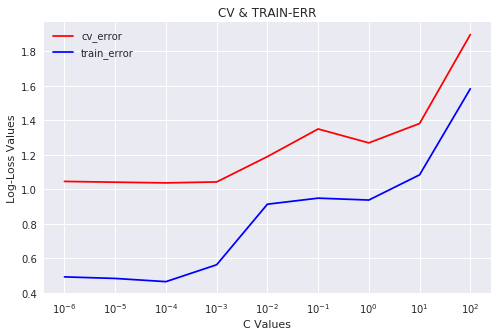

In [58]:
svm_model('Training', 'OneHotEncode')

Log-Loss for Train-set is : 0.9686144229375705
Log-Loss for Test-set is : 1.1795748871859382
Train Accuracy is : 0.722537207654146
Test Accuracy is : 0.6152304609218436
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


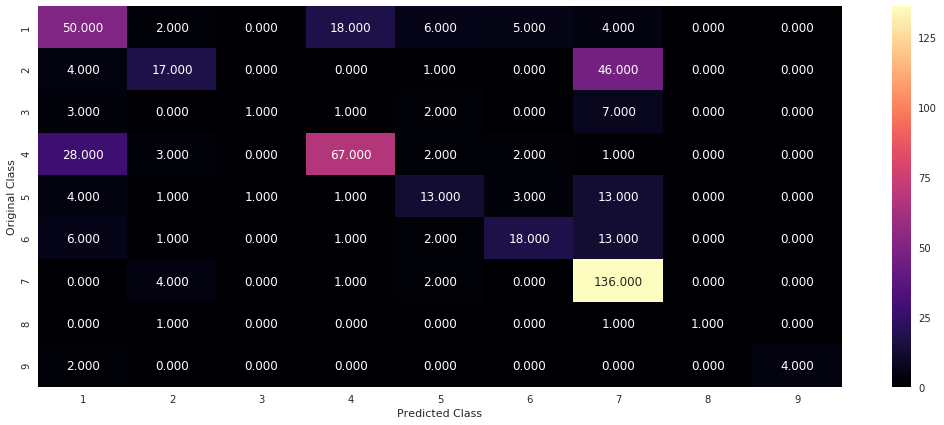

---------------------------------------- PRECISION-MATRIX ----------------------------------------


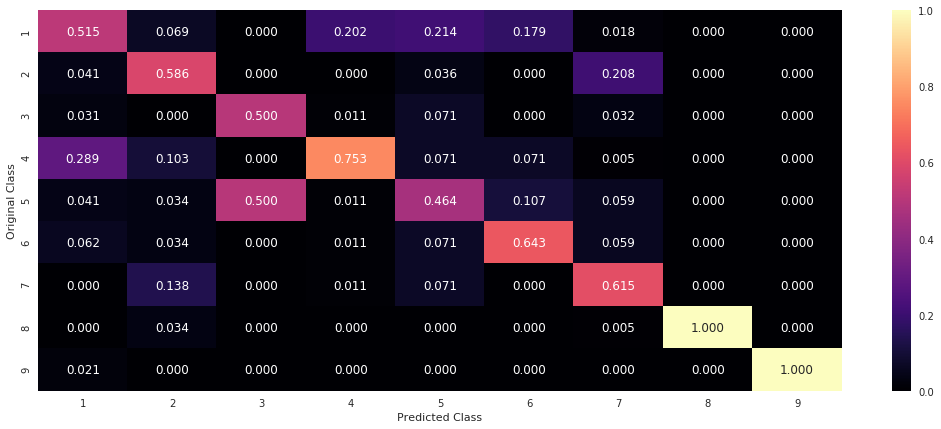

---------------------------------------- RECALL-MATRIX ----------------------------------------


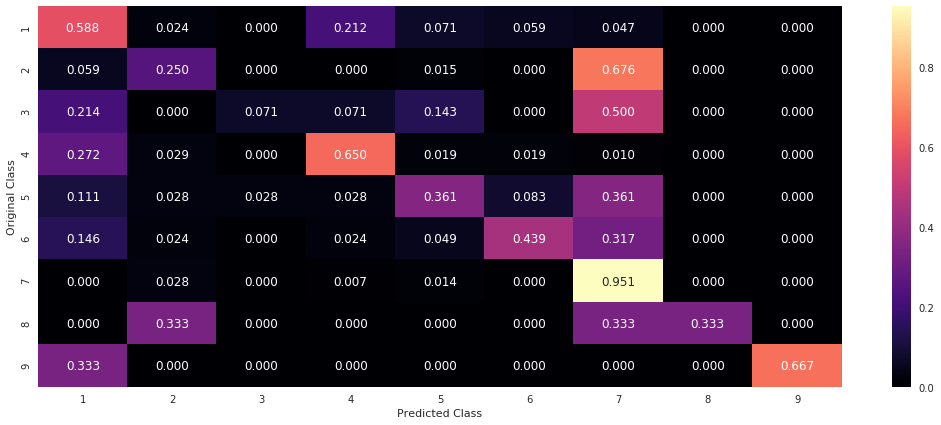

In [61]:
svm_model('Testing', 'OneHotEncode', best_c = 0.01)

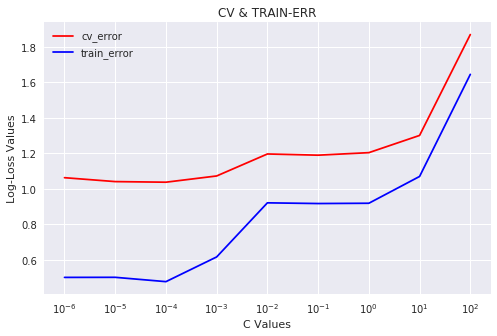

In [60]:
svm_model('Training', 'OneHotEncode', weight = 'balanced')

Log-Loss for Train-set is : 0.9723803499259398
Log-Loss for Test-set is : 1.1903889806697445
Train Accuracy is : 0.6977321048901488
Test Accuracy is : 0.3466933867735471
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


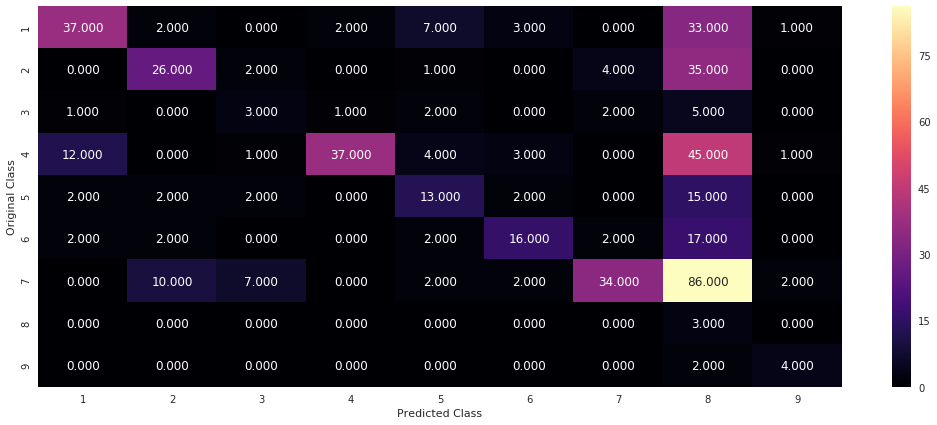

---------------------------------------- PRECISION-MATRIX ----------------------------------------


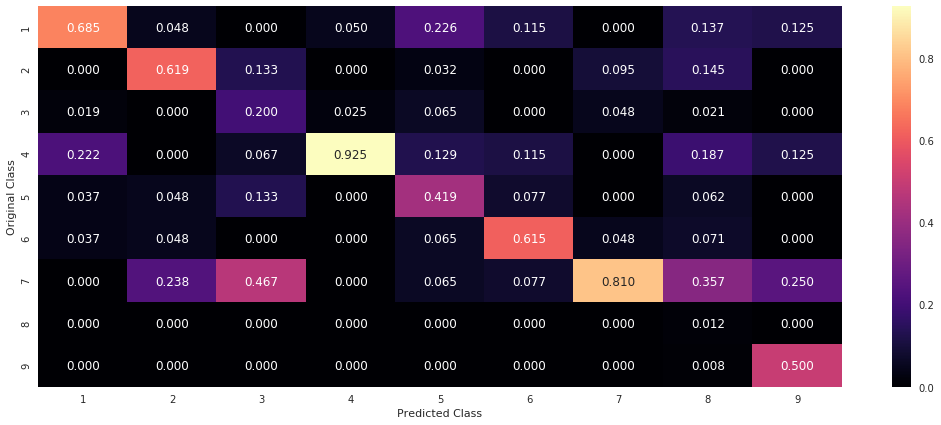

---------------------------------------- RECALL-MATRIX ----------------------------------------


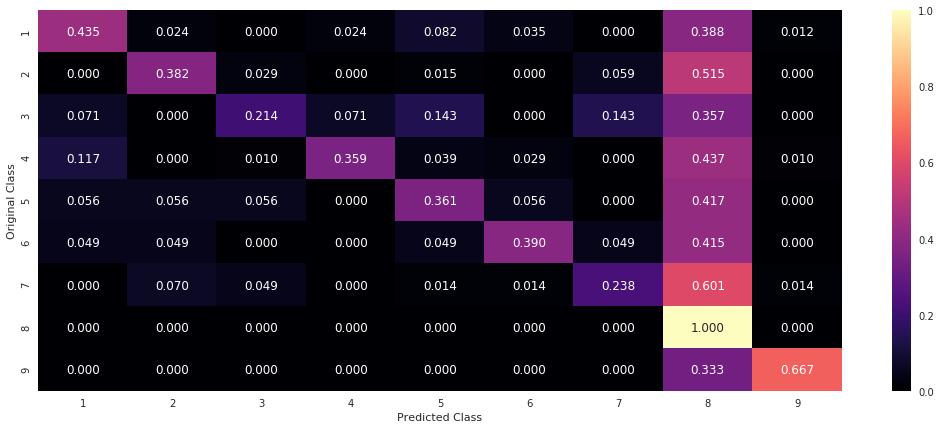

In [62]:
svm_model('Testing', 'OneHotEncode', best_c = 0.01, weight = 'balanced')

In [67]:
svm_query(0.01, 21)

Predicted Class Probabilities: [[0.1257 0.0527 0.0154 0.6268 0.0204 0.056  0.0909 0.0038 0.0082]]
Predicted Class :  4
Actual Class :  4
----------------------------------------
Feature from Gene : PTEN 0
Feature from Gene : CDKN2A 0
Feature from Gene : SPOP 1
Feature from Gene : NF1 0
Feature from Gene : RUNX1 0
Feature from Gene : KEAP1 0
Feature from Gene : VHL 0
Feature from Gene : STK11 0
Feature from Gene : PIK3R1 0
Feature from Gene : BAP1 0
Feature from Gene : CBL 0
Feature from Gene : SMARCA4 0
Feature from Gene : MAP2K4 0
Feature from TEXT pten 0.0
Feature from TEXT p16ink4a 0.0
Feature from Gene : TSC2 0
Feature from Gene : MSH2 0
Feature from Gene : TGFBR1 0
Feature from Gene : PPP6C 0
Feature from Gene : POLE 0
Feature from Gene : CDKN2B 0
Feature from TEXT phosphatase 0.005180072685932477
Feature from TEXT catalytic 0.005037732013324089
Feature from TEXT suppressor 0.0
Feature from Gene : B2M 0
Feature from Gene : PRDM1 0
Feature from Gene : FANCA 0
Feature from TEXT miss

In [69]:
svm_query(0.01, 50)

Predicted Class Probabilities: [[0.4926 0.0496 0.0114 0.2309 0.0356 0.0548 0.1076 0.0108 0.0068]]
Predicted Class :  1
Actual Class :  4
----------------------------------------
Feature from Variation : Truncating_Mutations 0
Feature from Variation : Deletion 0
Feature from Gene : ERCC2 0
Feature from Gene : TP53 1
Feature from Gene : PPP2R1A 0
Feature from Gene : NF2 0
Feature from Gene : FOXA1 0
Feature from Gene : SMAD2 0
Feature from Gene : CTCF 0
Feature from Gene : AGO2 0
Feature from TEXT deficient 0.0
Feature from TEXT deletion 0.0
Feature from TEXT repeats 0.0
Feature from Gene : PTPRD 0
Feature from Gene : PTPRT 0
Feature from Gene : RASA1 0
Feature from TEXT surface 0.0
Feature from TEXT nucleus 0.010839057258195579
Feature from Gene : FOXP1 0
Feature from Gene : RAD50 0
Feature from Gene : APC 0
Feature from Gene : CARM1 0
Feature from Gene : KNSTRN 0
Feature from TEXT loss 0.019924618192093565
Feature from TEXT functions 0.009145825797219316
Feature from Gene : BCL2L11 0
F

### 8.5 Random Forest Classifier 

In [101]:
from mpl_toolkits.mplot3d import Axes3D

def err_compare3D(train_err, cv_err, depths, n_bases):
    
    hypr = np.array([0,0])
    for i in n_bases:
        for j in depths:
            hypr = np.vstack([hypr, np.array([i, j])])
    hypr = hypr[1:,:]
    
    data_train = np.hstack([hypr, np.array(train_err).reshape(len(train_err),1)])
    df_train = pd.DataFrame(data_train)
    df_train.columns = ["# Base","Depth","Error"]
 
    # transforming the old column name in something numeric
    df_train['# Base'] = pd.Categorical(df_train['# Base'])
    df_train['# Base'] = df_train['# Base'].cat.codes
        
    ## plot for the train data
 
    # making the plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df_train['Depth'], df_train['# Base'], df_train['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
    ax.set_xlabel('Num Of Base-Models')
    ax.set_ylabel('Depth')
    ax.set_zlabel('Error')
    fig.suptitle('Train Error', fontsize = 18)
    # adding a color bar which maps values to colors.
    surf=ax.plot_trisurf(df_train['Depth'], df_train['# Base'], df_train['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
    fig.colorbar(surf, shrink=0.5, aspect=5)
 
    # rotation 
    ax.view_init(10, 60)
    plt.show()
    print('\n\n\n')
        
    ## plot for the cv data
        
    data_cv = np.hstack([hypr, np.array(cv_err).reshape(len(cv_err),1)])
    df_cv = pd.DataFrame(data_cv)
    df_cv.columns = ["# Base","Depth","Error"]
 
    # And transform the old column name in something numeric
    df_cv['# Base'] = pd.Categorical(df_cv['# Base'])
    df_cv['# Base'] = df_cv['# Base'].cat.codes
 
    # making the plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df_cv['Depth'], df_cv['# Base'], df_cv['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
    ax.set_xlabel('Num Of Base-Models')
    ax.set_ylabel('Depth')
    ax.set_zlabel('Error')
    fig.suptitle('CV Error', fontsize = 18)
 
    # adding a color bar which maps values to colors.
    surf=ax.plot_trisurf(df_cv['Depth'], df_cv['# Base'], df_cv['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
    fig.colorbar(surf, shrink=0.5, aspect=5)
 
    # rotation 
    ax.view_init(10, 60)
    plt.show()
    print('\n\n\n')

In [87]:
def rf_model(operation, encode_type, weight = None, best_depth = None, best_base = None, vectorizer = None, ngram = None):
    
    n_base = np.array([10, 50, 100, 250, 500, 750, 1000])
    depth = np.arange(2, 15, 3)
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for b in n_base:
            for d in depth:
                clf = RandomForestClassifier(n_estimators = b, max_depth = d, n_jobs = -1)
                clf.fit(trn_data, train_datay)
                sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
                sig_clf.fit(trn_data, train_datay)
                pred_proba_trn = sig_clf.predict_proba(trn_data)
                pred_proba_cv = sig_clf.predict_proba(cv_data)
                train_err.append(log_loss(train_datay, pred_proba_trn))
                cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare3D(train_err, cv_err, depth, n_base)
    else:
        clf = RandomForestClassifier(n_estimators = best_base, max_depth = best_depth, n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(trn_data, train_y)
        pred_proba_trn = sig_clf.predict_proba(trn_data)
        pred_proba_tst = sig_clf.predict_proba(tst_data)
        trn_err = clf.score(trn_data, train_y)
        tst_err = clf.score(tst_data, test_y)
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [115]:
def rf_query(best_depth, best_base, query_indx, weight = None, vectorizer = None, ngram = None):

    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode', vectorizer, ngram)
    clf = RandomForestClassifier(n_estimators = best_base, max_depth = best_depth, n_jobs = -1)
    clf.fit(trn_data, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(tst_data.iloc[query_indx].reshape(1, -1)), 4))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = np.argsort(-clf.feature_importances_)[:100]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for i in sorted_indices:
        if tst_data.columns[i] in np.unique(train_x['Gene']):
            print('Feature from Gene :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
        elif tst_data.columns[i] in np.unique(train_x['Variation']):
            print('Feature from Variation :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
        else:
            print('Feature from TEXT',tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
    present_word = []
    for i in sorted_indices:
        if tst_data.columns[i] in test_x['TEXT'].iloc[query_indx]:
            present_word.append(tst_data.columns[i])
    print('These Texts are present in the given query : ')
    print(present_word)

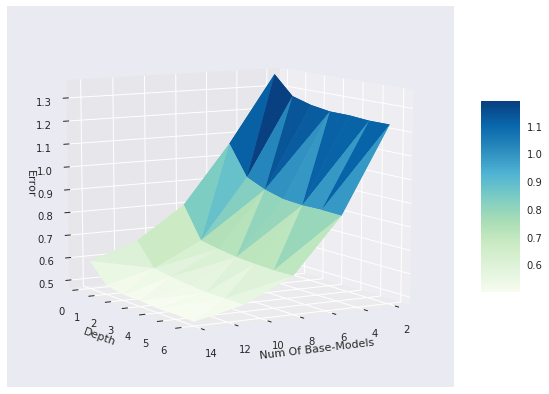

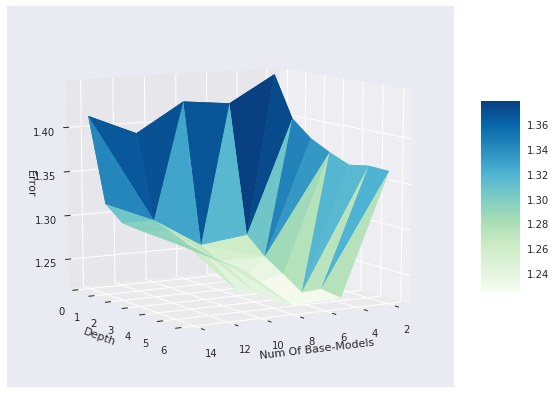

In [86]:
rf_model('Training', 'OneHotEncode')

Log-Loss for Train-set is : 0.8962452501010323
Log-Loss for Test-set is : 1.233918921329973
Train Accuracy is : 0.6378454996456414
Test Accuracy is : 0.5551102204408818
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


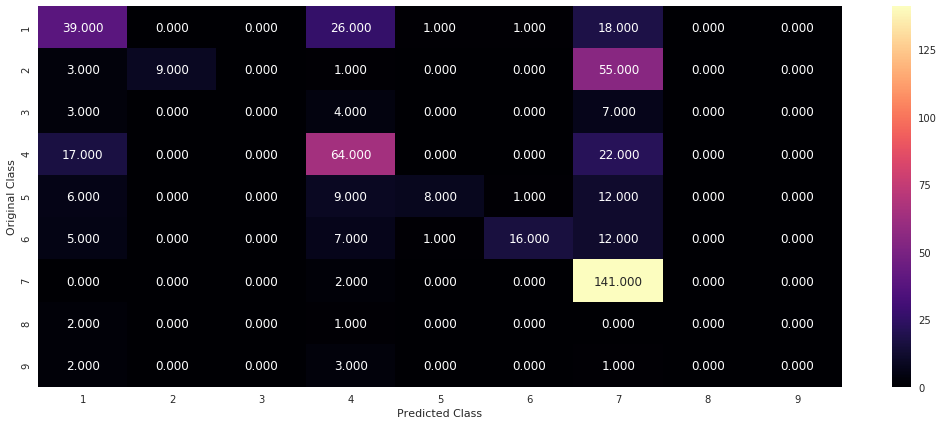

---------------------------------------- PRECISION-MATRIX ----------------------------------------


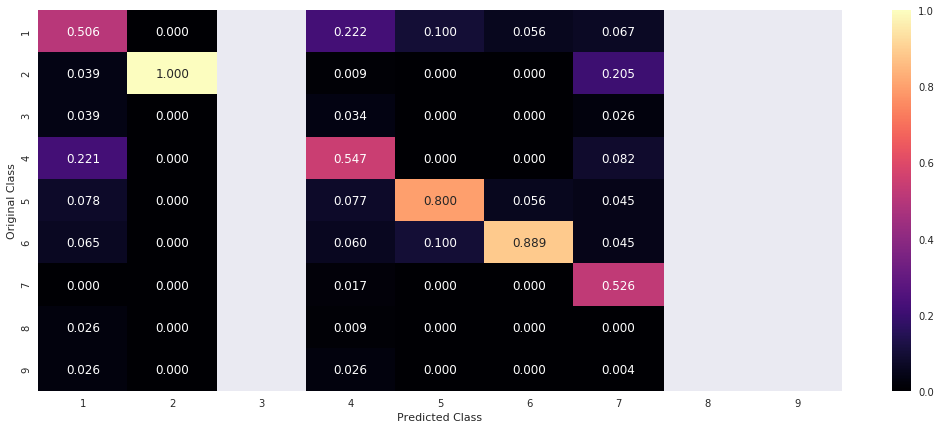

---------------------------------------- RECALL-MATRIX ----------------------------------------


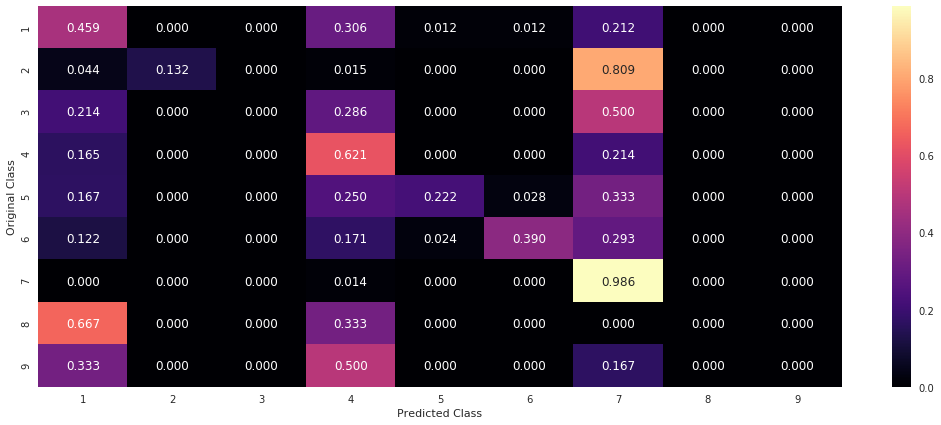

In [100]:
rf_model('Testing', 'OneHotEncode', best_depth = 5, best_base = 1000)

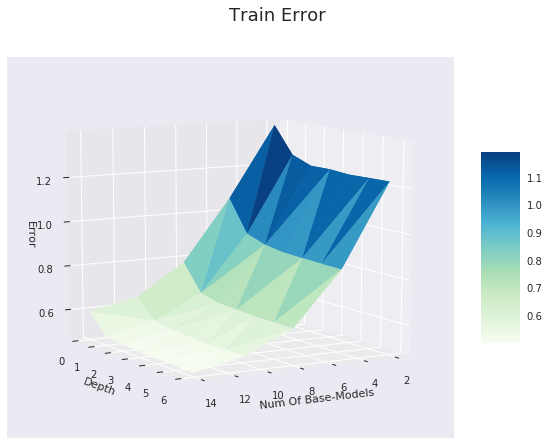

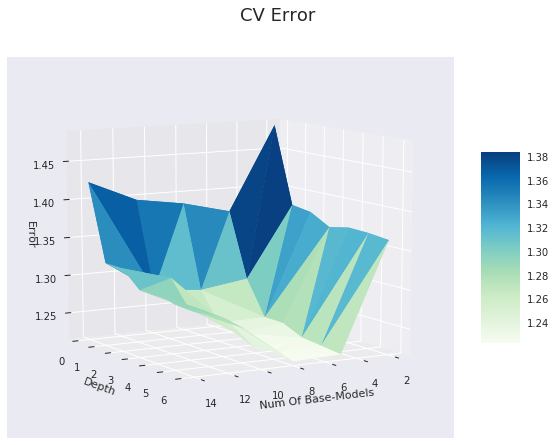

In [103]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced', np.unique(train_datay), train_datay)
rf_model('Training', 'OneHotEncode', weight = weights)

Log-Loss for Train-set is : 0.8984984151233527
Log-Loss for Test-set is : 1.2269919405126422
Train Accuracy is : 0.632884479092842
Test Accuracy is : 0.5470941883767535
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


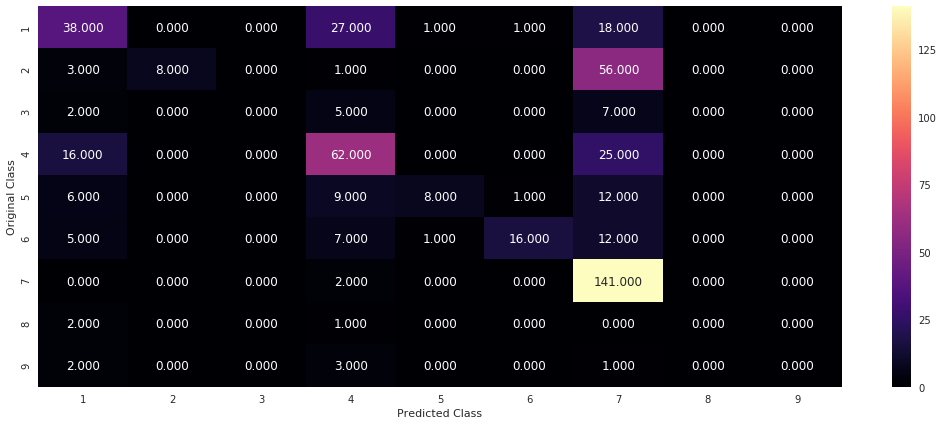

---------------------------------------- PRECISION-MATRIX ----------------------------------------


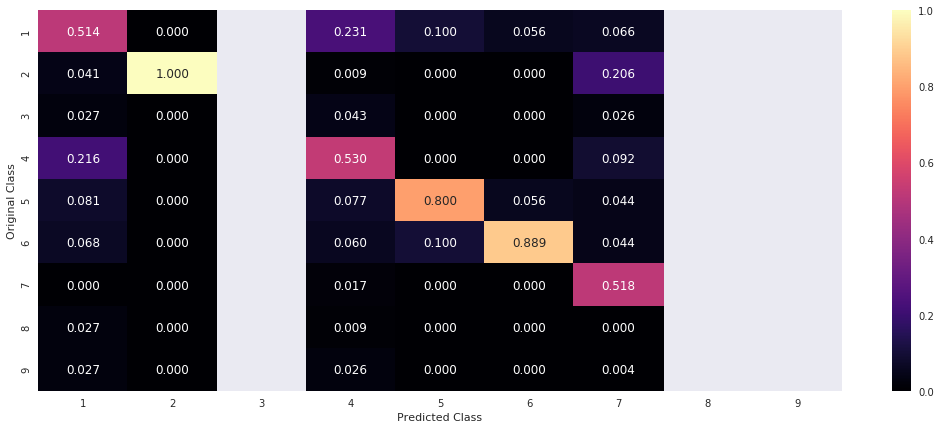

---------------------------------------- RECALL-MATRIX ----------------------------------------


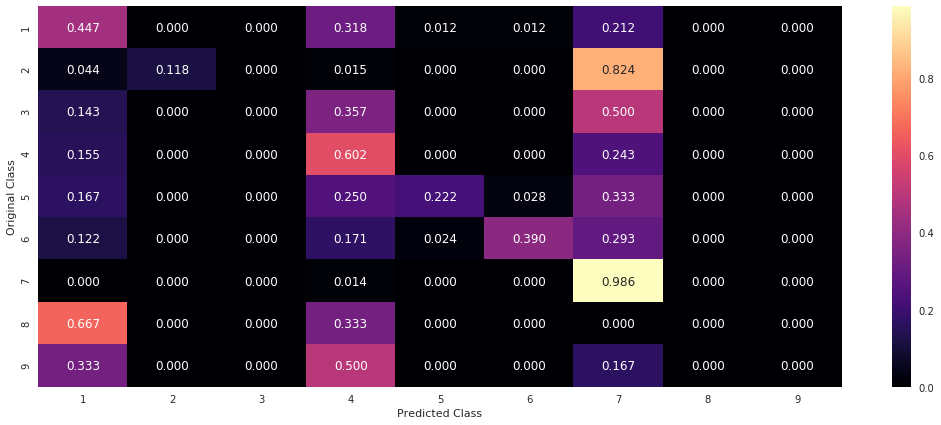

In [106]:
rf_model('Testing', 'OneHotEncode', weight = 'balanced_subsample', best_depth = 5, best_base = 1000)

In [116]:
rf_query(5, 1000, 21)

Predicted Class Probabilities: [[0.2235 0.082  0.022  0.2587 0.0606 0.0568 0.2762 0.0106 0.0096]]
Predicted Class :  7
Actual Class :  4
----------------------------------------
Feature from TEXT kinase 0.013309835854336465
Feature from TEXT activating 0.004044977257323032
Feature from TEXT tyrosine 0.0
Feature from TEXT inhibitors 0.0010158086543533575
Feature from TEXT suppressor 0.0
Feature from TEXT function 0.009884209458876613
Feature from TEXT activation 0.004336026597534016
Feature from TEXT activated 0.0
Feature from TEXT phosphorylation 0.0060388470361310165
Feature from TEXT constitutive 0.0028169400498718185
Feature from TEXT missense 0.0
Feature from TEXT loss 0.0028413287379619296
Feature from TEXT inhibitor 0.011288538778036657
Feature from TEXT erk 0.0
Feature from TEXT deleterious 0.0012488302132057573
Feature from TEXT brca1 0.0
Feature from TEXT treatment 0.01000165607699096
Feature from TEXT pathogenic 0.0
Feature from TEXT growth 0.008958368030735419
Feature from T

In [117]:
rf_query(5, 1000, 1)

Predicted Class Probabilities: [[0.4648 0.0406 0.0164 0.2359 0.0572 0.0597 0.1054 0.0099 0.0101]]
Predicted Class :  1
Actual Class :  1
----------------------------------------
Feature from TEXT kinase 0.0237275253312796
Feature from TEXT activating 0.0
Feature from TEXT tyrosine 0.0
Feature from TEXT function 0.16613746587971595
Feature from TEXT suppressor 0.0
Feature from TEXT activation 0.0072881546460390615
Feature from TEXT inhibitors 0.01195186255902071
Feature from TEXT activated 0.020457275741563835
Feature from TEXT phosphorylation 0.4973656075583744
Feature from TEXT loss 0.05571779425121235
Feature from TEXT constitutive 0.0
Feature from TEXT treatment 0.021396015745233733
Feature from TEXT deleterious 0.0
Feature from TEXT pathogenic 0.0
Feature from TEXT brca1 0.0
Feature from TEXT missense 0.0
Feature from TEXT therapy 0.0
Feature from TEXT inhibitor 0.0
Feature from TEXT erk 0.0
Feature from TEXT signaling 0.05019659606566131
Feature from TEXT pten 0.0
Feature from TEX